# Trabajo Práctico 4

# Imports y función de entrenamiento

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, zero_one_loss, accuracy_score
from sklearn.model_selection import train_test_split
import copy
import math
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, RadiusNeighborsClassifier, RadiusNeighborsRegressor
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [2]:
def entrenar_KNN(clf, max_k, X_train, y_train, X_val, y_val, X_test, y_test):
    if type(clf) == KNeighborsRegressor:
      error_fun = mean_squared_error
    else:
      error_fun = zero_one_loss
    best_clf = None
    best_error = 1.0
    train_errors = []
    val_errors = []
    test_errors = []
    for k in range(max_k):
        clf.n_neighbors = k+1
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_train)
        train_error = error_fun(y_train, y_pred)

        y_pred = clf.predict(X_val)
        val_error = error_fun(y_val, y_pred)

        y_pred = clf.predict(X_test)
        test_error = error_fun(y_test, y_pred)

        train_errors.append(train_error)
        val_errors.append(val_error)
        test_errors.append(test_error)
        if val_error < best_error:
            best_clf = copy.deepcopy(clf)
            best_error = val_error
    return best_clf, train_errors, val_errors, test_errors

In [3]:
def entrenar_KNN_radius(clf, distances, X_train, y_train, X_val, y_val, X_test, y_test):
    if type(clf) == RadiusNeighborsRegressor:
      error_fun = mean_squared_error
    else:
      error_fun = zero_one_loss
    best_clf = None
    best_error = 1.0
    train_errors = []
    val_errors = []
    test_errors = []

    for dist in distances:
        clf.radius = dist
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_train)
        train_error = error_fun(y_train, y_pred)

        y_pred = clf.predict(X_val)
        val_error = error_fun(y_val, y_pred)

        y_pred = clf.predict(X_test)
        test_error = error_fun(y_test, y_pred)

        train_errors.append(train_error)
        val_errors.append(val_error)
        test_errors.append(test_error)
        if val_error < best_error:
            best_clf = copy.deepcopy(clf)
            best_error = val_error
    return best_clf, train_errors, val_errors, test_errors

In [4]:
def entrenar_red(red, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test):
    if type(red) == MLPRegressor:
      error_fun = mean_squared_error
    else:
      error_fun = zero_one_loss

    best_red = red
    best_red_error = 1.0
    error_train = []
    error_val = []
    error_test = []

    for i in range(evaluaciones):
      red.fit(X_train, y_train)

      P_train = red.predict(X_train)
      error_train.append(error_fun(y_train, P_train))

      P_val = red.predict(X_val)
      red_error_val = error_fun(y_val, P_val)
      error_val.append(red_error_val)

      P_test = red.predict(X_test)
      error_test.append(error_fun(y_test, P_test))

      if red_error_val < best_red_error:
        best_red = copy.deepcopy(red)
        best_red_error = red_error_val

    return best_red, error_train, error_val, error_test

In [5]:
def entrenar_red_weight_decay(red, evaluaciones, X_train, y_train, X_test, y_test, weight_fun = np.square):
    if type(red) == MLPRegressor:
      error_fun = mean_squared_error
    else:
      error_fun = zero_one_loss

    error_train = []
    error_test = []
    weight_sum = []

    for i in range(evaluaciones):
      red.fit(X_train, y_train)

      P_train = red.predict(X_train)
      error_train.append(error_fun(y_train, P_train))

      P_test = red.predict(X_test)
      error_test.append(error_fun(y_test, P_test))

      weight_sum.append(np.sum([np.sum(weight_fun(w)) for w in red.coefs_]))

    return red, error_train, error_test, weight_sum

In [6]:
def cargar_csv(path, xcols=2, delim_whitespace=False):
    """
    Argumentos:
      path (str): ruta al archivo csv a cargar
      xcols (int): cantidad de columnas que representan las entradas,
        la columna restante representara la clase o dato de salida
    """
    df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
    X = df.loc[:, 0:(xcols-1)]
    y = df.loc[:, xcols]
    return X,y

In [7]:
def covM(d, C):
  return np.identity(d)*([(C*np.sqrt(d))**2]*d)

def diagonales(n, d, C):
  n0 = int(n/2)
  #Clase0
  c0 = [np.append(x, 0) for x in np.random.multivariate_normal([-1]*d, covM(d, C), n0)]
  #Clase1
  c1 = [np.append(x, 1) for x in np.random.multivariate_normal([1]*d, covM(d, C), n-n0)]

  flist = c0 + c1
  # Crear DataFrame
  df = pd.DataFrame(flist, columns=[f'dim_{i}' for i in range(d)] + ['class'])
  return df

def covM2(d, C):
  return np.identity(d)*([C**2]*d)

def paralelas(n, d, C):
  n0 = int(n/2)
  #Clase0
  c0 = [np.append(x, 0) for x in np.random.multivariate_normal([-1] + [0]*(d-1), covM2(d, C), n0)]
  #Clase1
  c1 = [np.append(x, 1) for x in np.random.multivariate_normal([1] + [0]*(d-1), covM2(d, C), n-n0)]

  flist = c0 + c1
  # Crear DataFrame
  df = pd.DataFrame(flist, columns=[f'dim_{i}' for i in range(d)] + ['class'])
  return df

In [8]:
def avg_errors(error_dict, count_for_avg = 20):
  errors_test = []
  errors_train = []
  for k, l in error_dict.items():
    sum_train = 0
    sum_test = 0
    for e in l:
      sum_train += e['error_train']
      sum_test += e['error_test']
    errors_test.append(sum_test/count_for_avg)
    errors_train.append(sum_train/count_for_avg)
  return errors_train, errors_test

# Ejercicio A

## Espirales originales

In [35]:
X_data, y_data = cargar_csv("./data/espirales_con_ruido/c_0.data", 2)
X_test, y_test = cargar_csv("./data/espirales_con_ruido/c_0.test", 2)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)

C:\Users\Certi\AppData\Local\Temp\ipykernel_15340\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
C:\Users\Certi\AppData\Local\Temp\ipykernel_15340\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)


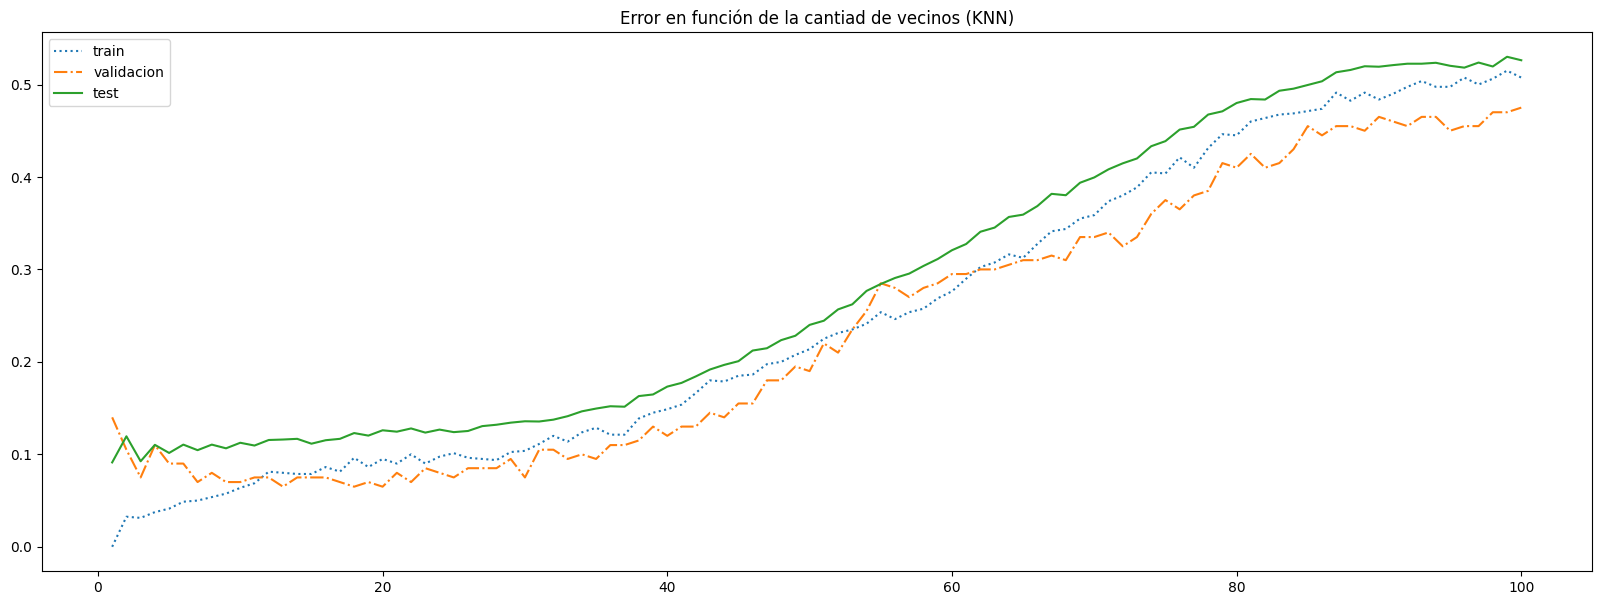

In [36]:
# KNN
max_k = 100
clf = KNeighborsClassifier()
best_clf_KNN, train_errors_KNN, val_errors_KNN, test_errors_KNN = entrenar_KNN(clf, max_k, X_train, y_train, X_val, y_val, X_test, y_test)

rango = range(1, max_k+1)
plt.figure(figsize=(20, 7))
plt.plot(rango, train_errors_KNN, label="train", linestyle=":")
plt.plot(rango, val_errors_KNN, label="validacion", linestyle="-.")
plt.plot(rango, test_errors_KNN, label="test", linestyle="-")
plt.title(f'Error en función de la cantiad de vecinos (KNN)')
plt.legend()
plt.show()

In [37]:
print(f"Mejor cantidad de vecinos: {best_clf_KNN.n_neighbors}")
print(f"Error en conjunto de entrenamiento: {train_errors_KNN[best_clf_KNN.n_neighbors-1]}")
print(f"Error en conjunto de validación: {val_errors_KNN[best_clf_KNN.n_neighbors-1]}")
print(f"Error en conjunto de test: {test_errors_KNN[best_clf_KNN.n_neighbors-1]}")

Mejor cantidad de vecinos: 13
Error en conjunto de entrenamiento: 0.07999999999999996
Error en conjunto de validación: 0.06499999999999995
Error en conjunto de test: 0.11599999999999999


In [38]:
t = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
t.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.002,
                       min_samples_leaf=5, random_state=0)

In [39]:
print(f"Error de arbol en conjunto de entrenamiento: {zero_one_loss(y_train, t.predict(X_train))}")
print(f"Error de arbol en conjunto de validación: {zero_one_loss(y_val, t.predict(X_val))}")
print(f"Error de arbol en conjunto de test: {zero_one_loss(y_test, t.predict(X_test))}")

Error de arbol en conjunto de entrenamiento: 0.06000000000000005
Error de arbol en conjunto de validación: 0.16500000000000004
Error de arbol en conjunto de test: 0.15500000000000003


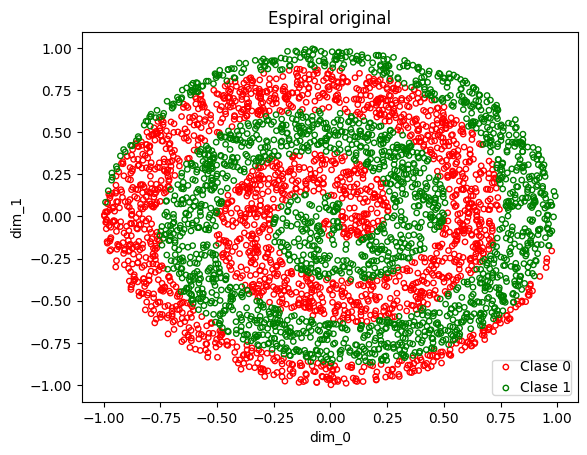

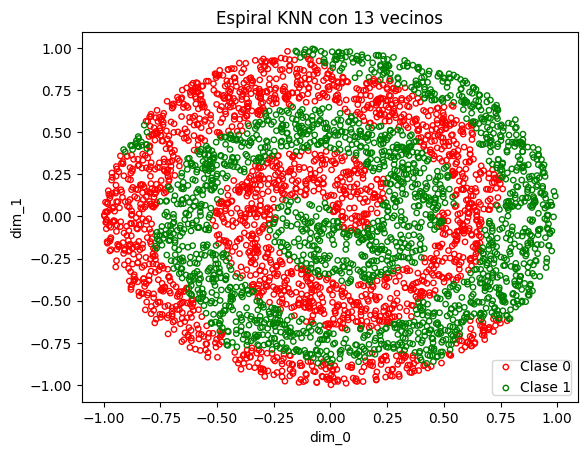

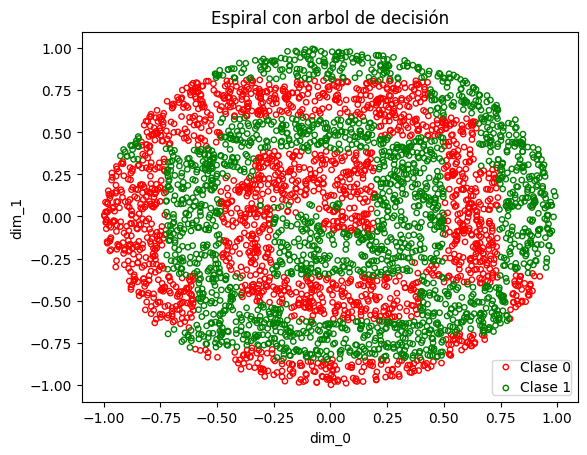

In [40]:
idx = np.where(y_test == 0)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(y_test == 1)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Espiral original')
plt.show()

P_test = best_clf_KNN.predict(X_test)

idx = np.where(P_test == 0)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)
idx = np.where(P_test == 1)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Espiral KNN con {best_clf_KNN.n_neighbors} vecinos')
plt.show()

P_test = t.predict(X_test)

idx = np.where(P_test == 0)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)
idx = np.where(P_test == 1)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Espiral con arbol de decisión')
plt.show()

## Espirales con ruido

In [41]:
X_data, y_data = cargar_csv("./data/espirales_con_ruido/c_2.data", 4)
X_test, y_test = cargar_csv("./data/espirales_con_ruido/c_2.test", 4)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)

C:\Users\Certi\AppData\Local\Temp\ipykernel_15340\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
C:\Users\Certi\AppData\Local\Temp\ipykernel_15340\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)


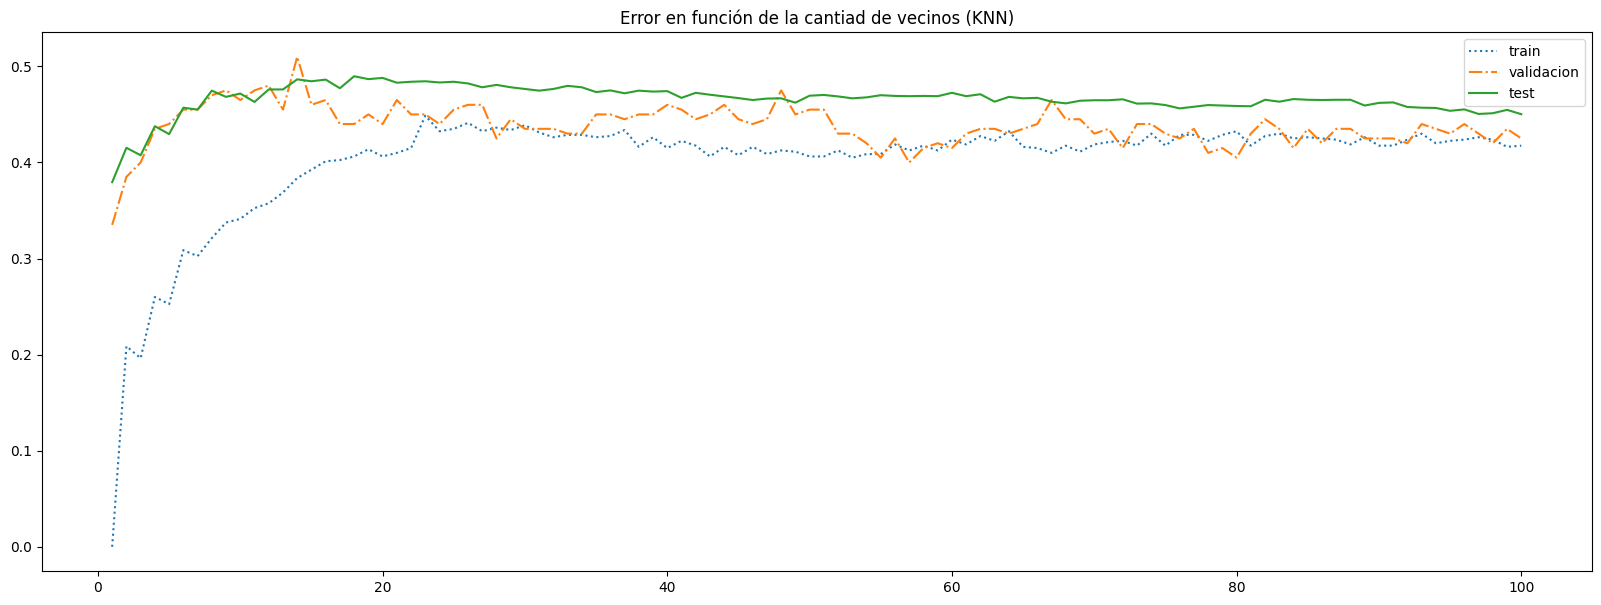

In [42]:
# KNN
max_k = 100
clf = KNeighborsClassifier()
best_clf_KNN, train_errors_KNN, val_errors_KNN, test_errors_KNN = entrenar_KNN(clf, max_k, X_train, y_train, X_val, y_val, X_test, y_test)

rango = range(1, max_k+1)
plt.figure(figsize=(20, 7))
plt.plot(rango, train_errors_KNN, label="train", linestyle=":")
plt.plot(rango, val_errors_KNN, label="validacion", linestyle="-.")
plt.plot(rango, test_errors_KNN, label="test", linestyle="-")
plt.title(f'Error en función de la cantiad de vecinos (KNN)')
plt.legend()
plt.show()

In [43]:
print(f"Mejor cantidad de vecinos: {best_clf_KNN.n_neighbors}")
print(f"Error en conjunto de entrenamiento: {train_errors_KNN[best_clf_KNN.n_neighbors-1]}")
print(f"Error en conjunto de validación: {val_errors_KNN[best_clf_KNN.n_neighbors-1]}")
print(f"Error en conjunto de test: {test_errors_KNN[best_clf_KNN.n_neighbors-1]}")

Mejor cantidad de vecinos: 1
Error en conjunto de entrenamiento: 0.0
Error en conjunto de validación: 0.33499999999999996
Error en conjunto de test: 0.37949999999999995


In [44]:
t = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
t.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.002,
                       min_samples_leaf=5, random_state=0)

In [45]:
print(f"Error de arbol en conjunto de entrenamiento: {zero_one_loss(y_train, t.predict(X_train))}")
print(f"Error de arbol en conjunto de validación: {zero_one_loss(y_val, t.predict(X_val))}")
print(f"Error de arbol en conjunto de test: {zero_one_loss(y_test, t.predict(X_test))}")

Error de arbol en conjunto de entrenamiento: 0.07125000000000004
Error de arbol en conjunto de validación: 0.20499999999999996
Error de arbol en conjunto de test: 0.1825


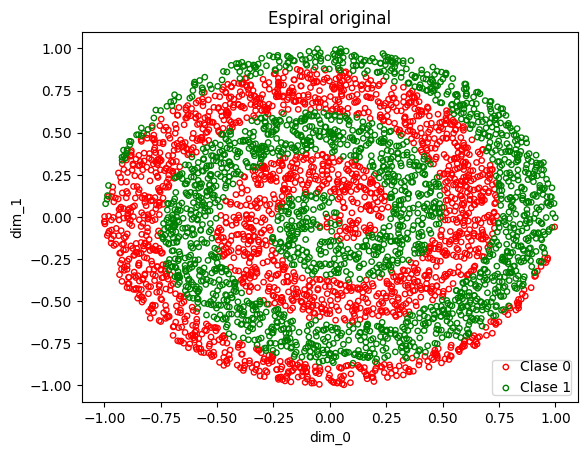

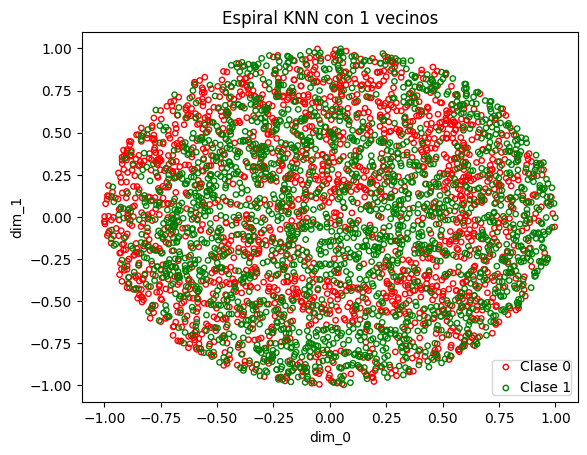

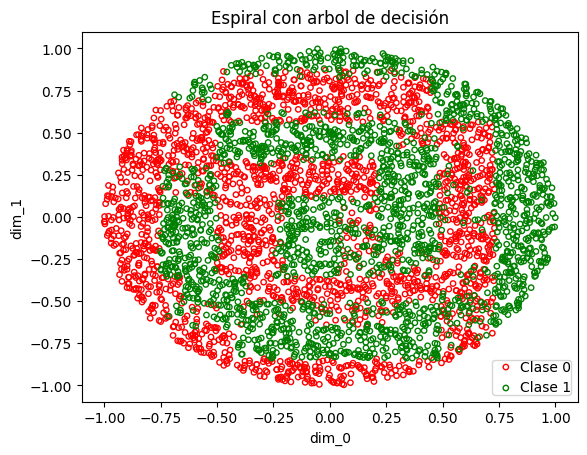

In [46]:
X_test_2_dims = X_test.iloc[:, 0:2]

idx = np.where(y_test == 0)
plt.scatter(
    X_test_2_dims.to_numpy()[idx, 0],
    X_test_2_dims.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(y_test == 1)
plt.scatter(
    X_test_2_dims.to_numpy()[idx, 0],
    X_test_2_dims.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Espiral original')
plt.show()

P_test = best_clf_KNN.predict(X_test)

idx = np.where(P_test == 0)
plt.scatter(
    X_test_2_dims.to_numpy()[idx, 0],
    X_test_2_dims.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)
idx = np.where(P_test == 1)
plt.scatter(
    X_test_2_dims.to_numpy()[idx, 0],
    X_test_2_dims.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Espiral KNN con {best_clf_KNN.n_neighbors} vecinos')
plt.show()

P_test = t.predict(X_test)

idx = np.where(P_test == 0)
plt.scatter(
    X_test_2_dims.to_numpy()[idx, 0],
    X_test_2_dims.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)
idx = np.where(P_test == 1)
plt.scatter(
    X_test_2_dims.to_numpy()[idx, 0],
    X_test_2_dims.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Espiral con arbol de decisión')
plt.show()

## Análisis

# Ejercicio B

In [21]:
C = 0.78
n_training = 250
n_testing = 10000
d_values = [2, 4, 8, 16, 32]
count_for_avg = 20

#defino parámetros de la red
epocas_por_entrenamiento=50     #numero de epocas que entrena cada vez
eta=0.1                         #learning rate
alfa=0.9                        #momentum
evaluaciones = 400
gamma = 0.0001
N2 = 6

## Diagonales

In [22]:
errors_diagonales_trees = {}
errors_diagonales_redes = {}
errors_diagonales_naive_bayes = {}
errors_diagonales_knn_1 = {}
errors_diagonales_knn_best = {}

for d in d_values:
  errors_list_trees = []
  errors_list_redes = []
  errors_list_naive_bayes = []
  errors_list_knn_1 = []
  errors_list_knn_best = []

  df_test = diagonales(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Diagonales, d={d}, iteración={i}")
    df_train = diagonales(n_training, d, C)
    y_train = df_train["class"].to_numpy()
    X_train = df_train.drop(columns=["class"]).to_numpy()

    # Naive Bayes
    clf = GaussianNB()
    clf.fit(X_train, y_train)

    predict_test = clf.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_naive_bayes.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

    # Redes
    clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    best_red, error_train, error_test, _ = entrenar_red_weight_decay(clasif, evaluaciones, X_train, y_train, X_test, y_test)

    errors_list_redes.append({'error_test': error_test[-1], 'error_train': error_train[-1]})

    # Árboles
    t = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    t.fit(X_train, y_train)

    predict_test = t.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = t.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_trees.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

    # KNN
    max_k = 100
    clf = KNeighborsClassifier()
    X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train, y_train, test_size = 0.2)
    best_clf_KNN, train_errors_KNN, val_errors_KNN, test_errors_KNN = entrenar_KNN(clf, max_k, X_train_2, y_train_2, X_val_2, y_val_2, X_test, y_test)

    errors_list_knn_1.append({'error_test': test_errors_KNN[0], 'error_train': train_errors_KNN[0]})
    errors_list_knn_best.append({'error_test': test_errors_KNN[best_clf_KNN.n_neighbors-1], 'error_train': train_errors_KNN[best_clf_KNN.n_neighbors-1]})

  errors_diagonales_redes[d] = errors_list_redes
  errors_diagonales_trees[d] = errors_list_trees
  errors_diagonales_naive_bayes[d] = errors_list_naive_bayes
  errors_diagonales_knn_1[d] = errors_list_knn_1
  errors_diagonales_knn_best[d] = errors_list_knn_best

Diagonales, d=2, iteración=0
Diagonales, d=2, iteración=1
Diagonales, d=2, iteración=2
Diagonales, d=2, iteración=3
Diagonales, d=2, iteración=4
Diagonales, d=2, iteración=5
Diagonales, d=2, iteración=6
Diagonales, d=2, iteración=7
Diagonales, d=2, iteración=8
Diagonales, d=2, iteración=9
Diagonales, d=2, iteración=10
Diagonales, d=2, iteración=11
Diagonales, d=2, iteración=12
Diagonales, d=2, iteración=13
Diagonales, d=2, iteración=14
Diagonales, d=2, iteración=15
Diagonales, d=2, iteración=16
Diagonales, d=2, iteración=17
Diagonales, d=2, iteración=18
Diagonales, d=2, iteración=19
Diagonales, d=4, iteración=0
Diagonales, d=4, iteración=1
Diagonales, d=4, iteración=2
Diagonales, d=4, iteración=3
Diagonales, d=4, iteración=4
Diagonales, d=4, iteración=5
Diagonales, d=4, iteración=6
Diagonales, d=4, iteración=7
Diagonales, d=4, iteración=8
Diagonales, d=4, iteración=9
Diagonales, d=4, iteración=10
Diagonales, d=4, iteración=11
Diagonales, d=4, iteración=12
Diagonales, d=4, iteración=13


In [23]:
errors_train_diagonales_tree_avg, errors_test_diagonales_tree_avg = avg_errors(errors_diagonales_trees)
errors_train_diagonales_red_avg, errors_test_diagonales_red_avg = avg_errors(errors_diagonales_redes)
errors_train_diagonales_naive_bayes_avg, errors_test_diagonales_naive_bayes_avg = avg_errors(errors_diagonales_naive_bayes)
errors_train_diagonales_knn_1_avg, errors_test_diagonales_knn_1_avg = avg_errors(errors_diagonales_knn_1)
errors_train_diagonales_knn_best_avg, errors_test_diagonales_knn_best_avg = avg_errors(errors_diagonales_knn_best)

## Paralelas

In [24]:
errors_paralelas_redes = {}
errors_paralelas_trees = {}
errors_paralelas_naive_bayes = {}
errors_paralelas_knn_1 = {}
errors_paralelas_knn_best = {}

for d in d_values:
  errors_list_trees = []
  errors_list_redes = []
  errors_list_naive_bayes = []
  errors_list_knn_1 = []
  errors_list_knn_best = []

  df_test = paralelas(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Paralelas, d={d}, iteración={i}")
    df_train = paralelas(n_training, d, C)
    y_train = df_train["class"].to_numpy()
    X_train = df_train.drop(columns=["class"]).to_numpy()

    # Naive Bayes
    clf = GaussianNB()
    clf.fit(X_train, y_train)

    predict_test = clf.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_naive_bayes.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

    # Redes
    clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    best_red, error_train, error_test, _ = entrenar_red_weight_decay(clasif, evaluaciones, X_train, y_train, X_test, y_test)

    errors_list_redes.append({'error_test': error_test[-1], 'error_train': error_train[-1]})

    # Árboles
    t = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    t.fit(X_train, y_train)

    predict_test = t.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = t.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_trees.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

    # KNN
    max_k = 100
    clf = KNeighborsClassifier()
    X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train, y_train, test_size = 0.2)
    best_clf_KNN, train_errors_KNN, val_errors_KNN, test_errors_KNN = entrenar_KNN(clf, max_k, X_train_2, y_train_2, X_val_2, y_val_2, X_test, y_test)

    errors_list_knn_1.append({'error_test': test_errors_KNN[0], 'error_train': train_errors_KNN[0]})
    errors_list_knn_best.append({'error_test': test_errors_KNN[best_clf_KNN.n_neighbors-1], 'error_train': train_errors_KNN[best_clf_KNN.n_neighbors-1]})
  
  errors_paralelas_redes[d] = errors_list_redes
  errors_paralelas_trees[d] = errors_list_trees
  errors_paralelas_naive_bayes[d] = errors_list_naive_bayes
  errors_paralelas_knn_1[d] = errors_list_knn_1
  errors_paralelas_knn_best[d] = errors_list_knn_best

Paralelas, d=2, iteración=0
Paralelas, d=2, iteración=1
Paralelas, d=2, iteración=2
Paralelas, d=2, iteración=3
Paralelas, d=2, iteración=4
Paralelas, d=2, iteración=5
Paralelas, d=2, iteración=6
Paralelas, d=2, iteración=7
Paralelas, d=2, iteración=8
Paralelas, d=2, iteración=9
Paralelas, d=2, iteración=10
Paralelas, d=2, iteración=11
Paralelas, d=2, iteración=12
Paralelas, d=2, iteración=13
Paralelas, d=2, iteración=14
Paralelas, d=2, iteración=15
Paralelas, d=2, iteración=16
Paralelas, d=2, iteración=17
Paralelas, d=2, iteración=18
Paralelas, d=2, iteración=19
Paralelas, d=4, iteración=0
Paralelas, d=4, iteración=1
Paralelas, d=4, iteración=2
Paralelas, d=4, iteración=3
Paralelas, d=4, iteración=4
Paralelas, d=4, iteración=5
Paralelas, d=4, iteración=6
Paralelas, d=4, iteración=7
Paralelas, d=4, iteración=8
Paralelas, d=4, iteración=9
Paralelas, d=4, iteración=10
Paralelas, d=4, iteración=11
Paralelas, d=4, iteración=12
Paralelas, d=4, iteración=13
Paralelas, d=4, iteración=14
Paral

In [25]:
errors_train_paralelas_tree_avg, errors_test_paralelas_tree_avg = avg_errors(errors_paralelas_trees)
errors_train_paralelas_red_avg, errors_test_paralelas_red_avg = avg_errors(errors_paralelas_redes)
errors_train_paralelas_naive_bayes_avg, errors_test_paralelas_naive_bayes_avg = avg_errors(errors_paralelas_naive_bayes)
errors_train_paralelas_knn_1_avg, errors_test_paralelas_knn_1_avg = avg_errors(errors_paralelas_knn_1)
errors_train_paralelas_knn_best_avg, errors_test_paralelas_knn_best_avg = avg_errors(errors_paralelas_knn_best)

## Gráficas

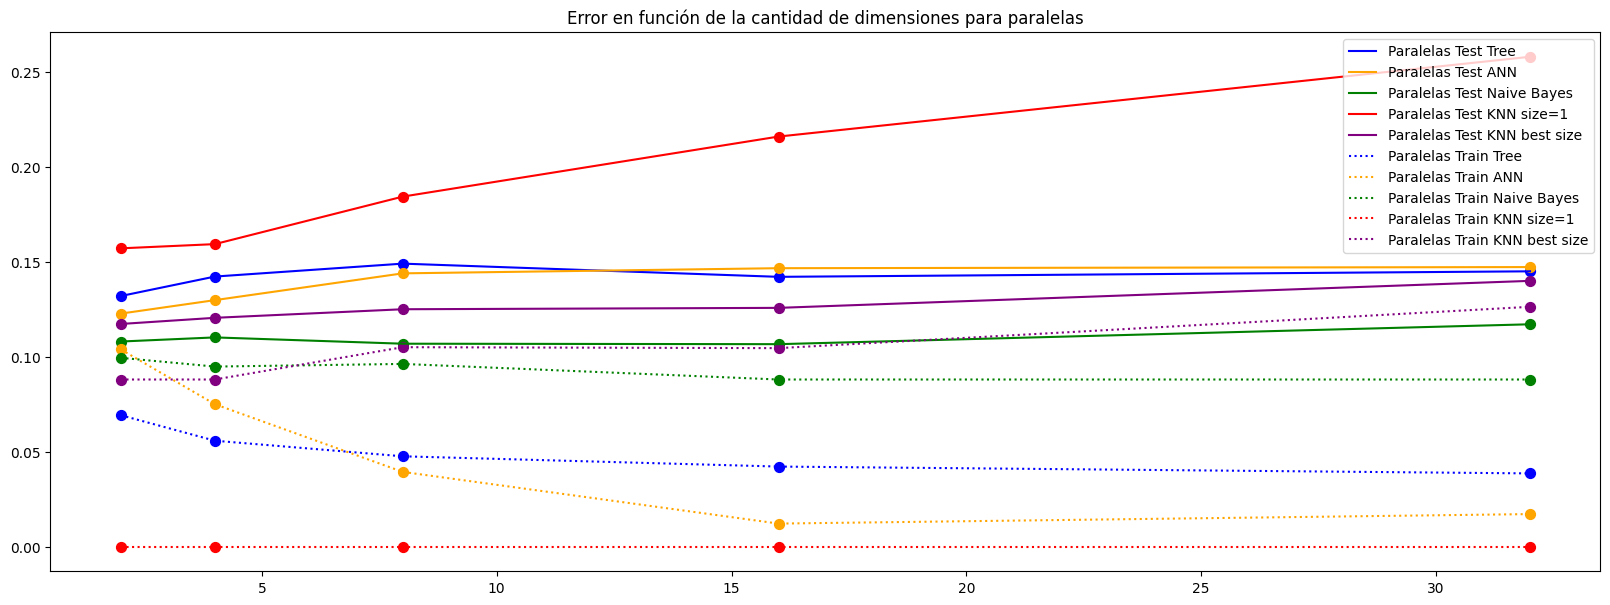

In [26]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_paralelas_tree_avg, label="Paralelas Test Tree", linestyle="-", color='blue')
plt.plot(d_values, errors_test_paralelas_red_avg, label="Paralelas Test ANN", linestyle="-", color='orange')
plt.plot(d_values, errors_test_paralelas_naive_bayes_avg, label="Paralelas Test Naive Bayes", linestyle="-", color='green')
plt.plot(d_values, errors_test_paralelas_knn_1_avg, label="Paralelas Test KNN size=1", linestyle="-", color='red')
plt.plot(d_values, errors_test_paralelas_knn_best_avg, label="Paralelas Test KNN best size", linestyle="-", color='purple')

plt.plot(d_values, errors_train_paralelas_tree_avg, label="Paralelas Train Tree", linestyle=":", color='blue')
plt.plot(d_values, errors_train_paralelas_red_avg, label="Paralelas Train ANN", linestyle=":", color='orange')
plt.plot(d_values, errors_train_paralelas_naive_bayes_avg, label="Paralelas Train Naive Bayes", linestyle=":", color='green')
plt.plot(d_values, errors_train_paralelas_knn_1_avg, label="Paralelas Train KNN size=1", linestyle=":", color='red')
plt.plot(d_values, errors_train_paralelas_knn_best_avg, label="Paralelas Train KNN best size", linestyle=":", color='purple')

plt.scatter(d_values, errors_test_paralelas_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_paralelas_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_paralelas_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_paralelas_knn_1_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_test_paralelas_knn_best_avg, color='purple', s=50) # puntos en violeta

plt.scatter(d_values, errors_train_paralelas_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_paralelas_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_paralelas_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_paralelas_knn_1_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_paralelas_knn_best_avg, color='purple', s=50) # puntos en violeta

plt.title(f'Error en función de la cantidad de dimensiones para paralelas')
plt.legend()
plt.show()

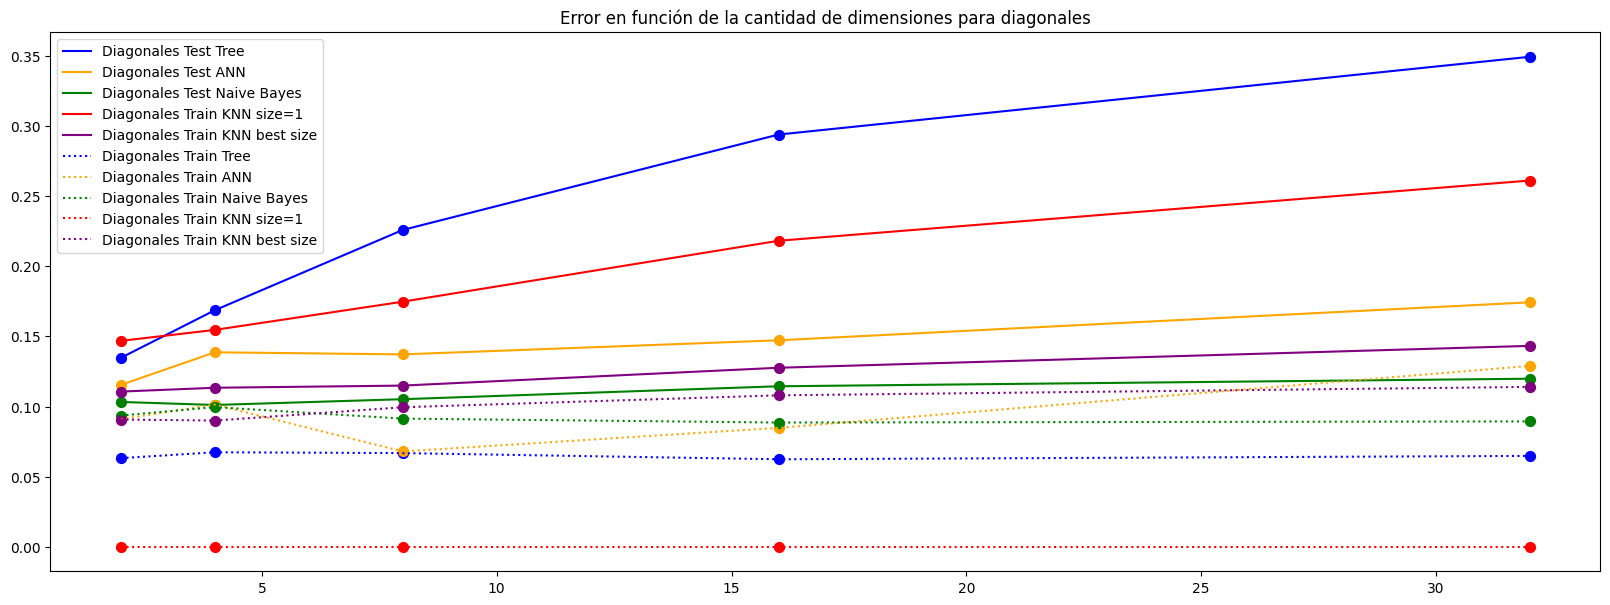

In [27]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_diagonales_tree_avg, label="Diagonales Test Tree", linestyle="-", color='blue')
plt.plot(d_values, errors_test_diagonales_red_avg, label="Diagonales Test ANN", linestyle="-", color='orange')
plt.plot(d_values, errors_test_diagonales_naive_bayes_avg, label="Diagonales Test Naive Bayes", linestyle="-", color='green')
plt.plot(d_values, errors_test_diagonales_knn_1_avg, label="Diagonales Train KNN size=1", linestyle="-", color='red')
plt.plot(d_values, errors_test_diagonales_knn_best_avg, label="Diagonales Train KNN best size", linestyle="-", color='purple')

plt.plot(d_values, errors_train_diagonales_tree_avg, label="Diagonales Train Tree", linestyle=":", color='blue')
plt.plot(d_values, errors_train_diagonales_red_avg, label="Diagonales Train ANN", linestyle=":", color='orange')
plt.plot(d_values, errors_train_diagonales_naive_bayes_avg, label="Diagonales Train Naive Bayes", linestyle=":", color='green')
plt.plot(d_values, errors_train_diagonales_knn_1_avg, label="Diagonales Train KNN size=1", linestyle=":", color='red')
plt.plot(d_values, errors_train_diagonales_knn_best_avg, label="Diagonales Train KNN best size", linestyle=":", color='purple')

plt.scatter(d_values, errors_test_diagonales_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_diagonales_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_diagonales_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_diagonales_knn_1_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_test_diagonales_knn_best_avg, color='purple', s=50) # puntos en violeta

plt.scatter(d_values, errors_train_diagonales_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_diagonales_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_diagonales_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_diagonales_knn_1_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_diagonales_knn_best_avg, color='purple', s=50) # puntos en violeta

plt.title(f'Error en función de la cantidad de dimensiones para diagonales')
plt.legend()
plt.show()


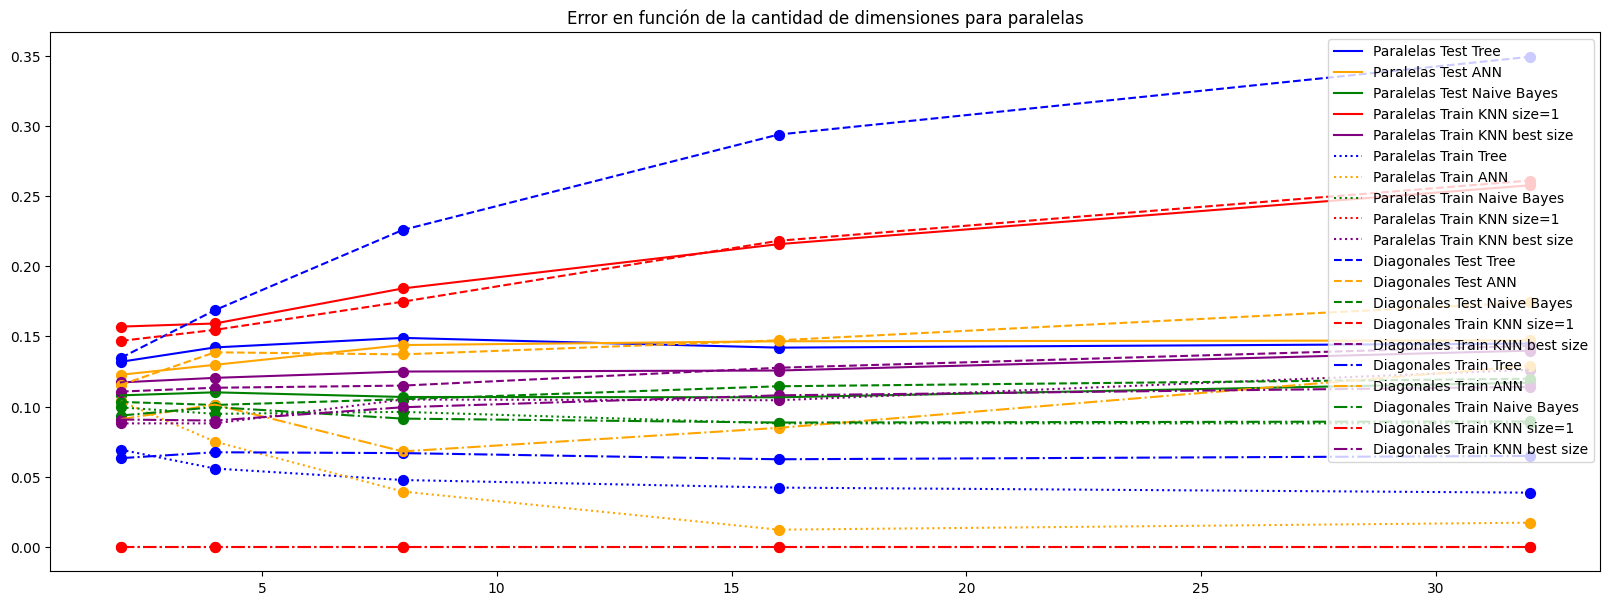

: 

In [28]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_paralelas_tree_avg, label="Paralelas Test Tree", linestyle="-", color='blue')
plt.plot(d_values, errors_test_paralelas_red_avg, label="Paralelas Test ANN", linestyle="-", color='orange')
plt.plot(d_values, errors_test_paralelas_naive_bayes_avg, label="Paralelas Test Naive Bayes", linestyle="-", color='green')
plt.plot(d_values, errors_test_paralelas_knn_1_avg, label="Paralelas Train KNN size=1", linestyle="-", color='red')
plt.plot(d_values, errors_test_paralelas_knn_best_avg, label="Paralelas Train KNN best size", linestyle="-", color='purple')

plt.plot(d_values, errors_train_paralelas_tree_avg, label="Paralelas Train Tree", linestyle=":", color='blue')
plt.plot(d_values, errors_train_paralelas_red_avg, label="Paralelas Train ANN", linestyle=":", color='orange')
plt.plot(d_values, errors_train_paralelas_naive_bayes_avg, label="Paralelas Train Naive Bayes", linestyle=":", color='green')
plt.plot(d_values, errors_train_paralelas_knn_1_avg, label="Paralelas Train KNN size=1", linestyle=":", color='red')
plt.plot(d_values, errors_train_paralelas_knn_best_avg, label="Paralelas Train KNN best size", linestyle=":", color='purple')

plt.plot(d_values, errors_test_diagonales_tree_avg, label="Diagonales Test Tree", linestyle="--", color='blue')
plt.plot(d_values, errors_test_diagonales_red_avg, label="Diagonales Test ANN", linestyle="--", color='orange')
plt.plot(d_values, errors_test_diagonales_naive_bayes_avg, label="Diagonales Test Naive Bayes", linestyle="--", color='green')
plt.plot(d_values, errors_test_diagonales_knn_1_avg, label="Diagonales Train KNN size=1", linestyle="--", color='red')
plt.plot(d_values, errors_test_diagonales_knn_best_avg, label="Diagonales Train KNN best size", linestyle="--", color='purple')

plt.plot(d_values, errors_train_diagonales_tree_avg, label="Diagonales Train Tree", linestyle="-.", color='blue')
plt.plot(d_values, errors_train_diagonales_red_avg, label="Diagonales Train ANN", linestyle="-.", color='orange')
plt.plot(d_values, errors_train_diagonales_naive_bayes_avg, label="Diagonales Train Naive Bayes", linestyle="-.", color='green')
plt.plot(d_values, errors_train_diagonales_knn_1_avg, label="Diagonales Train KNN size=1", linestyle="-.", color='red')
plt.plot(d_values, errors_train_diagonales_knn_best_avg, label="Diagonales Train KNN best size", linestyle="-.", color='purple')


plt.scatter(d_values, errors_test_paralelas_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_paralelas_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_paralelas_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_paralelas_knn_1_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_test_paralelas_knn_best_avg, color='purple', s=50) # puntos en violeta

plt.scatter(d_values, errors_train_paralelas_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_paralelas_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_paralelas_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_paralelas_knn_1_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_paralelas_knn_best_avg, color='purple', s=50) # puntos en violeta

plt.scatter(d_values, errors_test_diagonales_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_diagonales_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_diagonales_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_diagonales_knn_1_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_test_diagonales_knn_best_avg, color='purple', s=50) # puntos en violeta

plt.scatter(d_values, errors_train_diagonales_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_diagonales_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_diagonales_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_diagonales_knn_1_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_diagonales_knn_best_avg, color='purple', s=50) # puntos en violeta

plt.title(f'Error en función de la cantidad de dimensiones para paralelas')
plt.legend()
plt.show()

## Análisis

# Ejercicio C

In [11]:
C = 0.78
n_training = 250
n_testing = 10000
d_values = [2, 4, 8, 16, 32]
count_for_avg = 20
k_fijo = 50
max_k = 200

## Diagonales

Primero genero los errores para 32 dimensiones

In [113]:
d = 32
df_test = diagonales(n_testing, d, C)
y_test = df_test["class"].to_numpy()
X_test = df_test.drop(columns=["class"]).to_numpy()

df_train = diagonales(n_training, d, C)
y_data = df_train["class"].to_numpy()
X_data = df_train.drop(columns=["class"]).to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)
clf = KNeighborsClassifier(weights='distance')
_, train_errors_diagonales_32, val_errors_diagonales_32, test_errors_diagonales_32 = entrenar_KNN(clf, max_k, X_train, y_train, X_val, y_val, X_test, y_test)

Luego hago los promedios de ambos clasificadores en todas las dimensiones

In [12]:
errors_diagonales_knn_1 = {}
errors_diagonales_knn_best = {}
errors_diagonales_knn_weighted_fijo = {}
errors_diagonales_knn_weighted_best = {}

for d in d_values:
  errors_list_knn_1 = []
  errors_list_knn_best = []
  errors_list_knn_weighted_fijo = []
  errors_list_knn_weighted_best = []

  df_test = diagonales(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Diagonales, d={d}, iteración={i}")
    df_train = diagonales(n_training, d, C)
    y_data = df_train["class"].to_numpy()
    X_data = df_train.drop(columns=["class"]).to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)

    # KNN
    clf = KNeighborsClassifier()
    best_clf_KNN, train_errors_KNN, _, test_errors_KNN = entrenar_KNN(clf, max_k, X_train, y_train, X_val, y_val, X_test, y_test)

    errors_list_knn_1.append({'error_test': test_errors_KNN[0], 'error_train': train_errors_KNN[0]})
    errors_list_knn_best.append({'error_test': test_errors_KNN[best_clf_KNN.n_neighbors-1], 'error_train': train_errors_KNN[best_clf_KNN.n_neighbors-1]})

    # KNN weighted
    clf = KNeighborsClassifier(weights='distance')
    best_clf_KNN, train_errors_KNN, _, test_errors_KNN = entrenar_KNN(clf, max_k, X_train, y_train, X_val, y_val, X_test, y_test)

    errors_list_knn_weighted_fijo.append({'error_test': test_errors_KNN[k_fijo-1], 'error_train': train_errors_KNN[k_fijo-1]})
    errors_list_knn_weighted_best.append({'error_test': test_errors_KNN[best_clf_KNN.n_neighbors-1], 'error_train': train_errors_KNN[best_clf_KNN.n_neighbors-1]})

  errors_diagonales_knn_1[d] = errors_list_knn_1
  errors_diagonales_knn_best[d] = errors_list_knn_best
  errors_diagonales_knn_weighted_fijo[d] = errors_list_knn_weighted_fijo
  errors_diagonales_knn_weighted_best[d] = errors_list_knn_weighted_best

Diagonales, d=2, iteración=0
Diagonales, d=2, iteración=1
Diagonales, d=2, iteración=2
Diagonales, d=2, iteración=3
Diagonales, d=2, iteración=4
Diagonales, d=2, iteración=5
Diagonales, d=2, iteración=6
Diagonales, d=2, iteración=7
Diagonales, d=2, iteración=8
Diagonales, d=2, iteración=9
Diagonales, d=2, iteración=10
Diagonales, d=2, iteración=11
Diagonales, d=2, iteración=12
Diagonales, d=2, iteración=13
Diagonales, d=2, iteración=14
Diagonales, d=2, iteración=15
Diagonales, d=2, iteración=16
Diagonales, d=2, iteración=17
Diagonales, d=2, iteración=18
Diagonales, d=2, iteración=19
Diagonales, d=4, iteración=0
Diagonales, d=4, iteración=1
Diagonales, d=4, iteración=2
Diagonales, d=4, iteración=3
Diagonales, d=4, iteración=4
Diagonales, d=4, iteración=5
Diagonales, d=4, iteración=6
Diagonales, d=4, iteración=7
Diagonales, d=4, iteración=8
Diagonales, d=4, iteración=9
Diagonales, d=4, iteración=10
Diagonales, d=4, iteración=11
Diagonales, d=4, iteración=12
Diagonales, d=4, iteración=13


In [13]:
errors_train_diagonales_knn_1_avg, errors_test_diagonales_knn_1_avg = avg_errors(errors_diagonales_knn_1)
errors_train_diagonales_knn_best_avg, errors_test_diagonales_knn_best_avg = avg_errors(errors_diagonales_knn_best)
errors_train_diagonales_knn_weighted_fijo_avg, errors_test_diagonales_knn_weighted_fijo_avg = avg_errors(errors_diagonales_knn_weighted_fijo)
errors_train_diagonales_knn_weighted_best_avg, errors_test_diagonales_knn_weighted_best_avg = avg_errors(errors_diagonales_knn_weighted_best)

## Paralelas

Primero genero los errores para 32 dimensiones

In [40]:
d = 32
df_test = paralelas(n_testing, d, C)
y_test = df_test["class"].to_numpy()
X_test = df_test.drop(columns=["class"]).to_numpy()

df_train = paralelas(n_training, d, C)
y_data = df_train["class"].to_numpy()
X_data = df_train.drop(columns=["class"]).to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)
clf = KNeighborsClassifier(weights='distance')
_, train_errors_paralelas_32, val_errors_paralelas_32, test_errors_paralelas_32 = entrenar_KNN(clf, max_k, X_train, y_train, X_val, y_val, X_test, y_test)

Luego hago los promedios de ambos clasificadores en todas las dimensiones

In [14]:
errors_paralelas_knn_1 = {}
errors_paralelas_knn_best = {}
errors_paralelas_knn_weighted_fijo = {}
errors_paralelas_knn_weighted_best = {}

for d in d_values:
  errors_list_knn_1 = []
  errors_list_knn_best = []
  errors_list_knn_weighted_fijo = []
  errors_list_knn_weighted_best = []

  df_test = paralelas(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Paralelas, d={d}, iteración={i}")
    df_train = paralelas(n_training, d, C)
    y_data = df_train["class"].to_numpy()
    X_data = df_train.drop(columns=["class"]).to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)

    # KNN
    clf = KNeighborsClassifier()
    best_clf_KNN, train_errors_KNN, _, test_errors_KNN = entrenar_KNN(clf, max_k, X_train, y_train, X_val, y_val, X_test, y_test)

    errors_list_knn_1.append({'error_test': test_errors_KNN[0], 'error_train': train_errors_KNN[0]})
    errors_list_knn_best.append({'error_test': test_errors_KNN[best_clf_KNN.n_neighbors-1], 'error_train': train_errors_KNN[best_clf_KNN.n_neighbors-1]})
  
    # KNN weighted
    clf = KNeighborsClassifier(weights='distance')
    best_clf_KNN, train_errors_KNN, _, test_errors_KNN = entrenar_KNN(clf, max_k, X_train, y_train, X_val, y_val, X_test, y_test)

    errors_list_knn_weighted_fijo.append({'error_test': test_errors_KNN[k_fijo-1], 'error_train': train_errors_KNN[k_fijo-1]})
    errors_list_knn_weighted_best.append({'error_test': test_errors_KNN[best_clf_KNN.n_neighbors-1], 'error_train': train_errors_KNN[best_clf_KNN.n_neighbors-1]})

  errors_paralelas_knn_1[d] = errors_list_knn_1
  errors_paralelas_knn_best[d] = errors_list_knn_best
  errors_paralelas_knn_weighted_fijo[d] = errors_list_knn_weighted_fijo
  errors_paralelas_knn_weighted_best[d] = errors_list_knn_weighted_best

Paralelas, d=2, iteración=0
Paralelas, d=2, iteración=1
Paralelas, d=2, iteración=2
Paralelas, d=2, iteración=3
Paralelas, d=2, iteración=4
Paralelas, d=2, iteración=5
Paralelas, d=2, iteración=6
Paralelas, d=2, iteración=7
Paralelas, d=2, iteración=8
Paralelas, d=2, iteración=9
Paralelas, d=2, iteración=10
Paralelas, d=2, iteración=11
Paralelas, d=2, iteración=12
Paralelas, d=2, iteración=13
Paralelas, d=2, iteración=14
Paralelas, d=2, iteración=15
Paralelas, d=2, iteración=16
Paralelas, d=2, iteración=17
Paralelas, d=2, iteración=18
Paralelas, d=2, iteración=19
Paralelas, d=4, iteración=0
Paralelas, d=4, iteración=1
Paralelas, d=4, iteración=2
Paralelas, d=4, iteración=3
Paralelas, d=4, iteración=4
Paralelas, d=4, iteración=5
Paralelas, d=4, iteración=6
Paralelas, d=4, iteración=7
Paralelas, d=4, iteración=8
Paralelas, d=4, iteración=9
Paralelas, d=4, iteración=10
Paralelas, d=4, iteración=11
Paralelas, d=4, iteración=12
Paralelas, d=4, iteración=13
Paralelas, d=4, iteración=14
Paral

In [15]:
errors_train_paralelas_knn_1_avg, errors_test_paralelas_knn_1_avg = avg_errors(errors_paralelas_knn_1)
errors_train_paralelas_knn_best_avg, errors_test_paralelas_knn_best_avg = avg_errors(errors_paralelas_knn_best)
errors_train_paralelas_knn_weighted_fijo_avg, errors_test_paralelas_knn_weighted_fijo_avg = avg_errors(errors_paralelas_knn_weighted_fijo)
errors_train_paralelas_knn_weighted_best_avg, errors_test_paralelas_knn_weighted_best_avg = avg_errors(errors_paralelas_knn_weighted_best)

## Gráficas

### 32 dimensiones

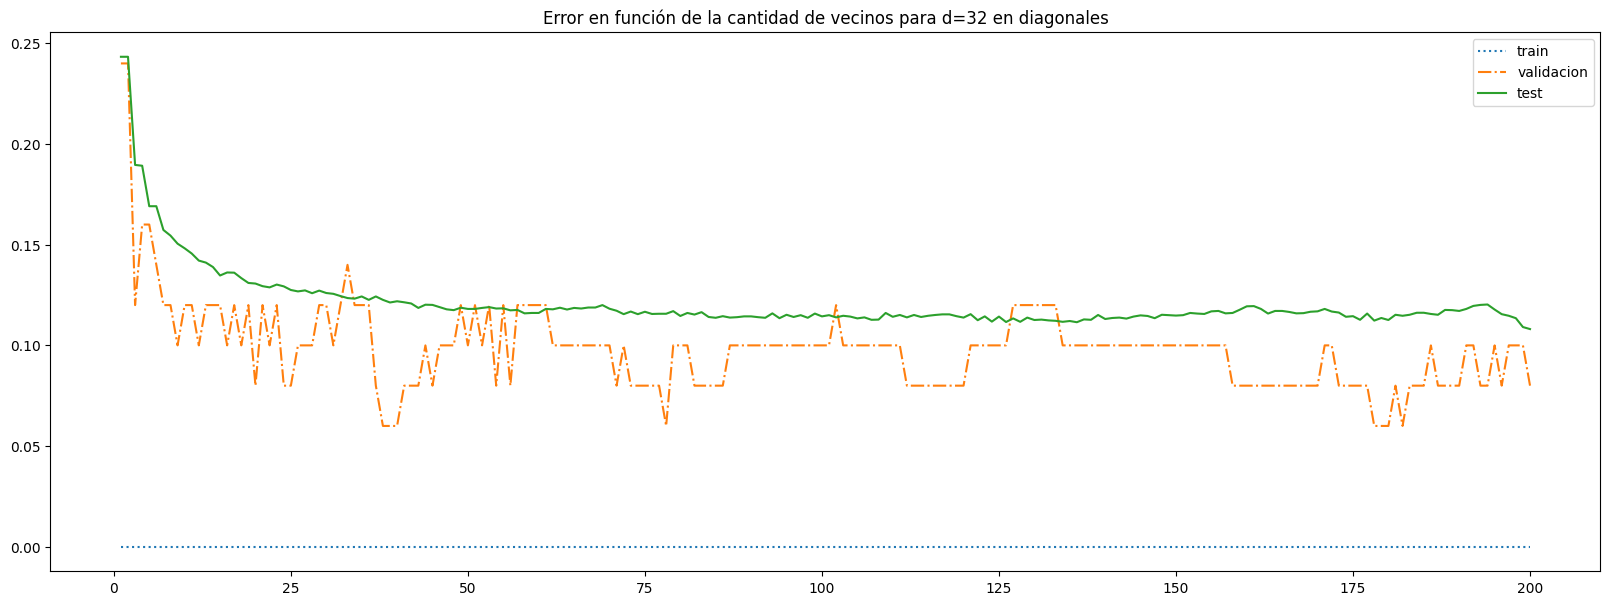

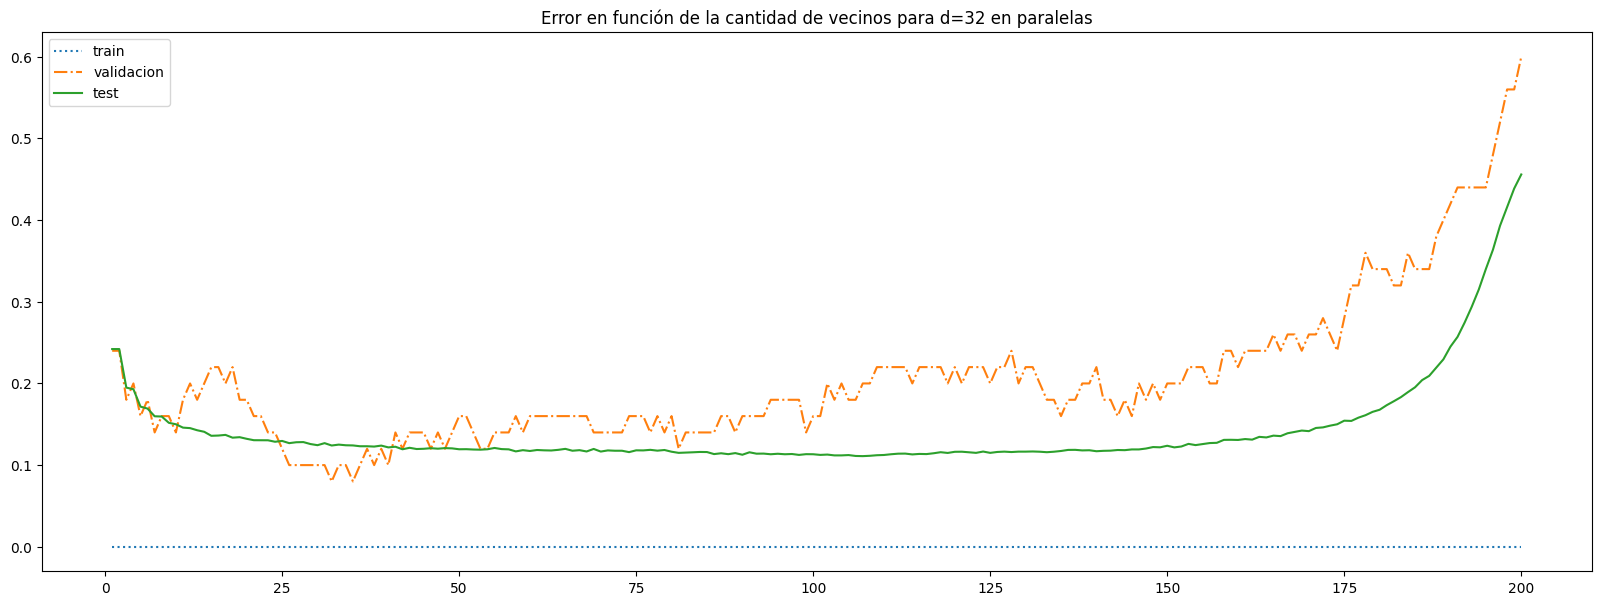

In [41]:
rango = range(1, max_k+1)
plt.figure(figsize=(20, 7))
plt.plot(rango, train_errors_diagonales_32, label="train", linestyle=":")
plt.plot(rango, val_errors_diagonales_32, label="validacion", linestyle="-.")
plt.plot(rango, test_errors_diagonales_32, label="test", linestyle="-")
plt.title(f'Error en función de la cantidad de vecinos para d=32 en diagonales')
plt.legend()
plt.show()

rango = range(1, max_k+1)
plt.figure(figsize=(20, 7))
plt.plot(rango, train_errors_paralelas_32, label="train", linestyle=":")
plt.plot(rango, val_errors_paralelas_32, label="validacion", linestyle="-.")
plt.plot(rango, test_errors_paralelas_32, label="test", linestyle="-")
plt.title(f'Error en función de la cantidad de vecinos para d=32 en paralelas')
plt.legend()
plt.show()

### Errores por dimensión

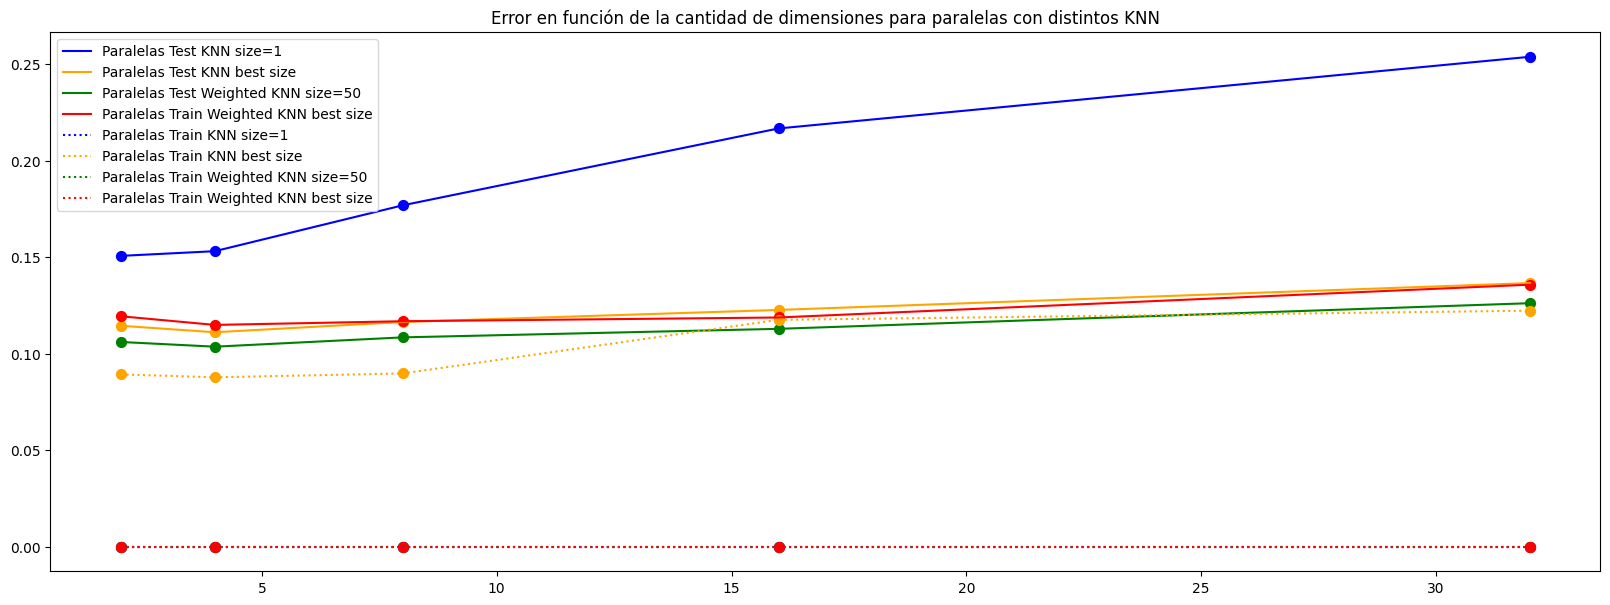

In [16]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_paralelas_knn_1_avg, label="Paralelas Test KNN size=1", linestyle="-", color='blue')
plt.plot(d_values, errors_test_paralelas_knn_best_avg, label="Paralelas Test KNN best size", linestyle="-", color='orange')
plt.plot(d_values, errors_test_paralelas_knn_weighted_fijo_avg, label="Paralelas Test Weighted KNN size=50", linestyle="-", color='green')
plt.plot(d_values, errors_test_paralelas_knn_weighted_best_avg, label="Paralelas Train Weighted KNN best size", linestyle="-", color='red')

plt.plot(d_values, errors_train_paralelas_knn_1_avg, label="Paralelas Train KNN size=1", linestyle=":", color='blue')
plt.plot(d_values, errors_train_paralelas_knn_best_avg, label="Paralelas Train KNN best size", linestyle=":", color='orange')
plt.plot(d_values, errors_train_paralelas_knn_weighted_fijo_avg, label="Paralelas Train Weighted KNN size=50", linestyle=":", color='green')
plt.plot(d_values, errors_train_paralelas_knn_weighted_best_avg, label="Paralelas Train Weighted KNN best size", linestyle=":", color='red')

plt.scatter(d_values, errors_test_paralelas_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_paralelas_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_paralelas_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_paralelas_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo

plt.scatter(d_values, errors_train_paralelas_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_paralelas_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_paralelas_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_paralelas_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo

plt.title(f'Error en función de la cantidad de dimensiones para paralelas con distintos KNN')
plt.legend()
plt.show()

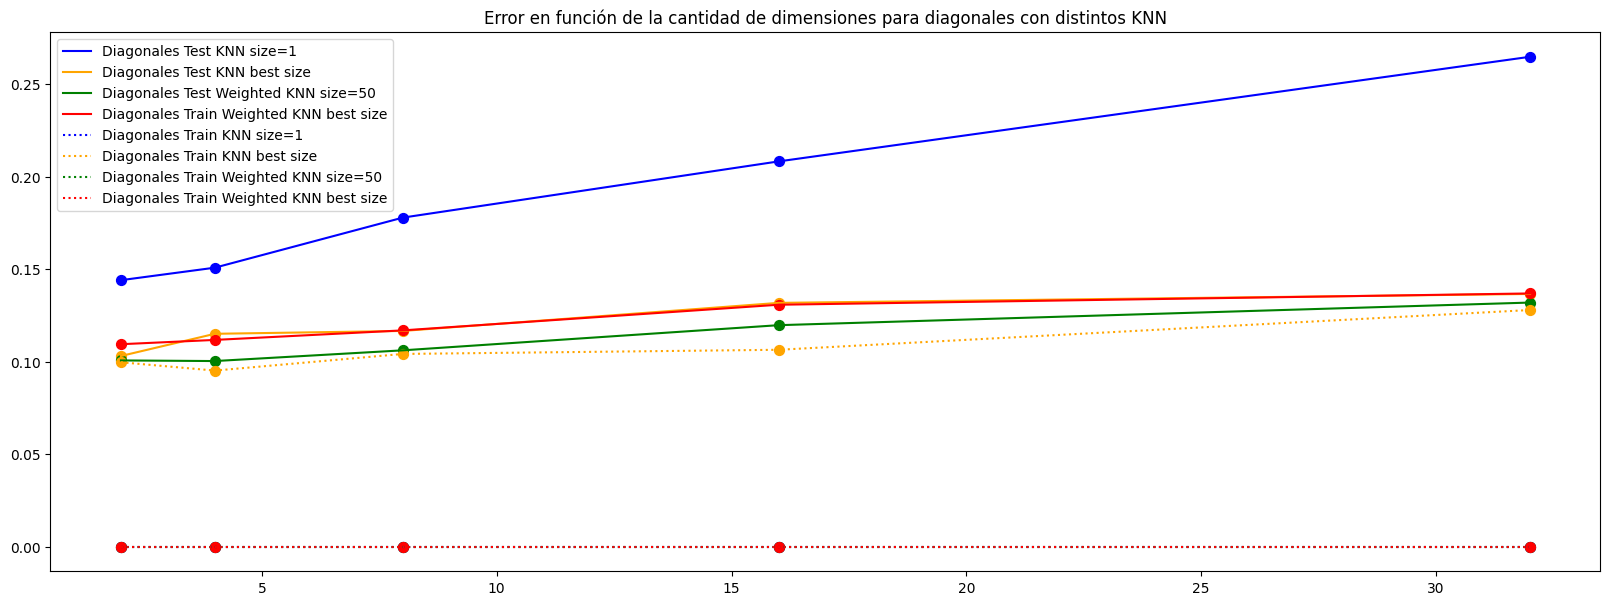

In [17]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_diagonales_knn_1_avg, label="Diagonales Test KNN size=1", linestyle="-", color='blue')
plt.plot(d_values, errors_test_diagonales_knn_best_avg, label="Diagonales Test KNN best size", linestyle="-", color='orange')
plt.plot(d_values, errors_test_diagonales_knn_weighted_fijo_avg, label="Diagonales Test Weighted KNN size=50", linestyle="-", color='green')
plt.plot(d_values, errors_test_diagonales_knn_weighted_best_avg, label="Diagonales Train Weighted KNN best size", linestyle="-", color='red')

plt.plot(d_values, errors_train_diagonales_knn_1_avg, label="Diagonales Train KNN size=1", linestyle=":", color='blue')
plt.plot(d_values, errors_train_diagonales_knn_best_avg, label="Diagonales Train KNN best size", linestyle=":", color='orange')
plt.plot(d_values, errors_train_diagonales_knn_weighted_fijo_avg, label="Diagonales Train Weighted KNN size=50", linestyle=":", color='green')
plt.plot(d_values, errors_train_diagonales_knn_weighted_best_avg, label="Diagonales Train Weighted KNN best size", linestyle=":", color='red')

plt.scatter(d_values, errors_test_diagonales_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_diagonales_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_diagonales_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_diagonales_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo

plt.scatter(d_values, errors_train_diagonales_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_diagonales_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_diagonales_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_diagonales_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo

plt.title(f'Error en función de la cantidad de dimensiones para diagonales con distintos KNN')
plt.legend()
plt.show()

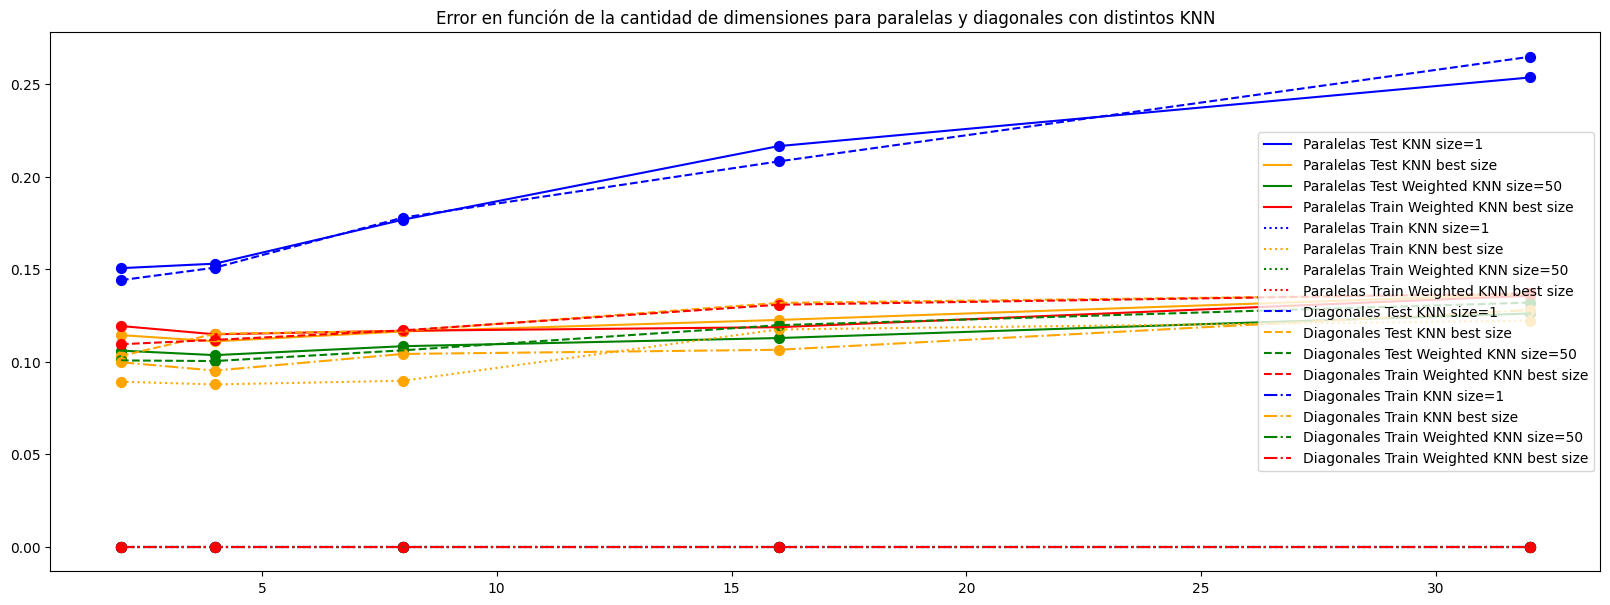

In [18]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_paralelas_knn_1_avg, label="Paralelas Test KNN size=1", linestyle="-", color='blue')
plt.plot(d_values, errors_test_paralelas_knn_best_avg, label="Paralelas Test KNN best size", linestyle="-", color='orange')
plt.plot(d_values, errors_test_paralelas_knn_weighted_fijo_avg, label="Paralelas Test Weighted KNN size=50", linestyle="-", color='green')
plt.plot(d_values, errors_test_paralelas_knn_weighted_best_avg, label="Paralelas Train Weighted KNN best size", linestyle="-", color='red')

plt.plot(d_values, errors_train_paralelas_knn_1_avg, label="Paralelas Train KNN size=1", linestyle=":", color='blue')
plt.plot(d_values, errors_train_paralelas_knn_best_avg, label="Paralelas Train KNN best size", linestyle=":", color='orange')
plt.plot(d_values, errors_train_paralelas_knn_weighted_fijo_avg, label="Paralelas Train Weighted KNN size=50", linestyle=":", color='green')
plt.plot(d_values, errors_train_paralelas_knn_weighted_best_avg, label="Paralelas Train Weighted KNN best size", linestyle=":", color='red')

plt.plot(d_values, errors_test_diagonales_knn_1_avg, label="Diagonales Test KNN size=1", linestyle="--", color='blue')
plt.plot(d_values, errors_test_diagonales_knn_best_avg, label="Diagonales Test KNN best size", linestyle="--", color='orange')
plt.plot(d_values, errors_test_diagonales_knn_weighted_fijo_avg, label="Diagonales Test Weighted KNN size=50", linestyle="--", color='green')
plt.plot(d_values, errors_test_diagonales_knn_weighted_best_avg, label="Diagonales Train Weighted KNN best size", linestyle="--", color='red')

plt.plot(d_values, errors_train_diagonales_knn_1_avg, label="Diagonales Train KNN size=1", linestyle="-.", color='blue')
plt.plot(d_values, errors_train_diagonales_knn_best_avg, label="Diagonales Train KNN best size", linestyle="-.", color='orange')
plt.plot(d_values, errors_train_diagonales_knn_weighted_fijo_avg, label="Diagonales Train Weighted KNN size=50", linestyle="-.", color='green')
plt.plot(d_values, errors_train_diagonales_knn_weighted_best_avg, label="Diagonales Train Weighted KNN best size", linestyle="-.", color='red')

plt.scatter(d_values, errors_test_paralelas_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_paralelas_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_paralelas_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_paralelas_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo

plt.scatter(d_values, errors_train_paralelas_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_paralelas_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_paralelas_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_paralelas_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo

plt.scatter(d_values, errors_test_diagonales_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_diagonales_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_diagonales_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_diagonales_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo

plt.scatter(d_values, errors_train_diagonales_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_diagonales_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_diagonales_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_diagonales_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo


plt.title(f'Error en función de la cantidad de dimensiones para paralelas y diagonales con distintos KNN')
plt.legend()
plt.show()

## Análisis

# Ejercicio D

## Ikeda

In [9]:
X_data, y_data = cargar_csv("./data/ikeda.data", 5, delim_whitespace=True)
X_test_aux, y_test_aux = cargar_csv("./data/ikeda.test", 5, delim_whitespace=True)

X_test, _, y_test, _ = train_test_split(X_test_aux, y_test_aux, test_size = 0.58333333)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.25)

C:\Users\Certi\AppData\Local\Temp\ipykernel_31364\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
C:\Users\Certi\AppData\Local\Temp\ipykernel_31364\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)


In [10]:
#defino parámetros de la red
epocas_por_entrenamiento=50     #numero de epocas que entrena cada vez
eta=0.01                         #learning rate
alfa=0.9                        #momentum
evaluaciones = 400
N2 = 30

In [11]:
regr = MLPRegressor(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train_red, error_val_red, error_test_red = entrenar_red(regr, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)

In [12]:
regr_knn = KNeighborsRegressor(weights='distance')

best_knn, error_train_knn, error_val_knn, error_test_knn = entrenar_KNN(regr_knn, len(y_train), X_train, y_train, X_val, y_val, X_test, y_test)

In [13]:
P_test = best_red.predict(X_test)
error_test = mean_squared_error(y_test, P_test)

P_train = best_red.predict(X_train)
error_train = mean_squared_error(y_train, P_train)

P_val = best_red.predict(X_val)
error_val = mean_squared_error(y_val, P_val)

print(f"Error de test de la mejor red: {error_test}")
print(f"Error de train de la mejor red: {error_train}")
print(f"Error de val de la mejor red: {error_val}")

P_test = best_knn.predict(X_test)
error_test = mean_squared_error(y_test, P_test)

P_train = best_knn.predict(X_train)
error_train = mean_squared_error(y_train, P_train)

P_val = best_knn.predict(X_val)
error_val = mean_squared_error(y_val, P_val)

print(f"Error de test del mejor KNN: {error_test}")
print(f"Error de train del mejor KNN: {error_train}")
print(f"Error de val del mejor KNN: {error_val}")

Error de test de la mejor red: 0.19525936782858125
Error de train de la mejor red: 0.1742841648158514
Error de val de la mejor red: 0.19179637189124538
Error de test del mejor KNN: 0.14066509196614477
Error de train del mejor KNN: 0.0
Error de val del mejor KNN: 0.19432542936392147


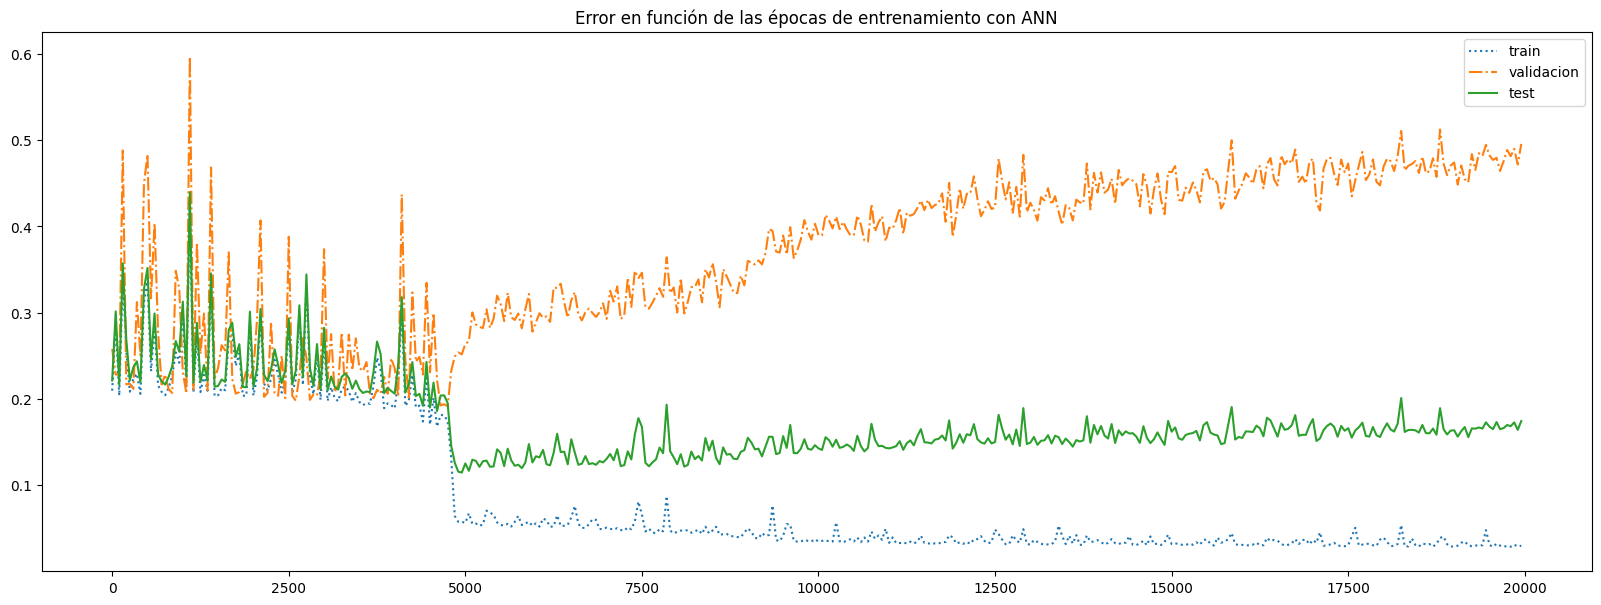

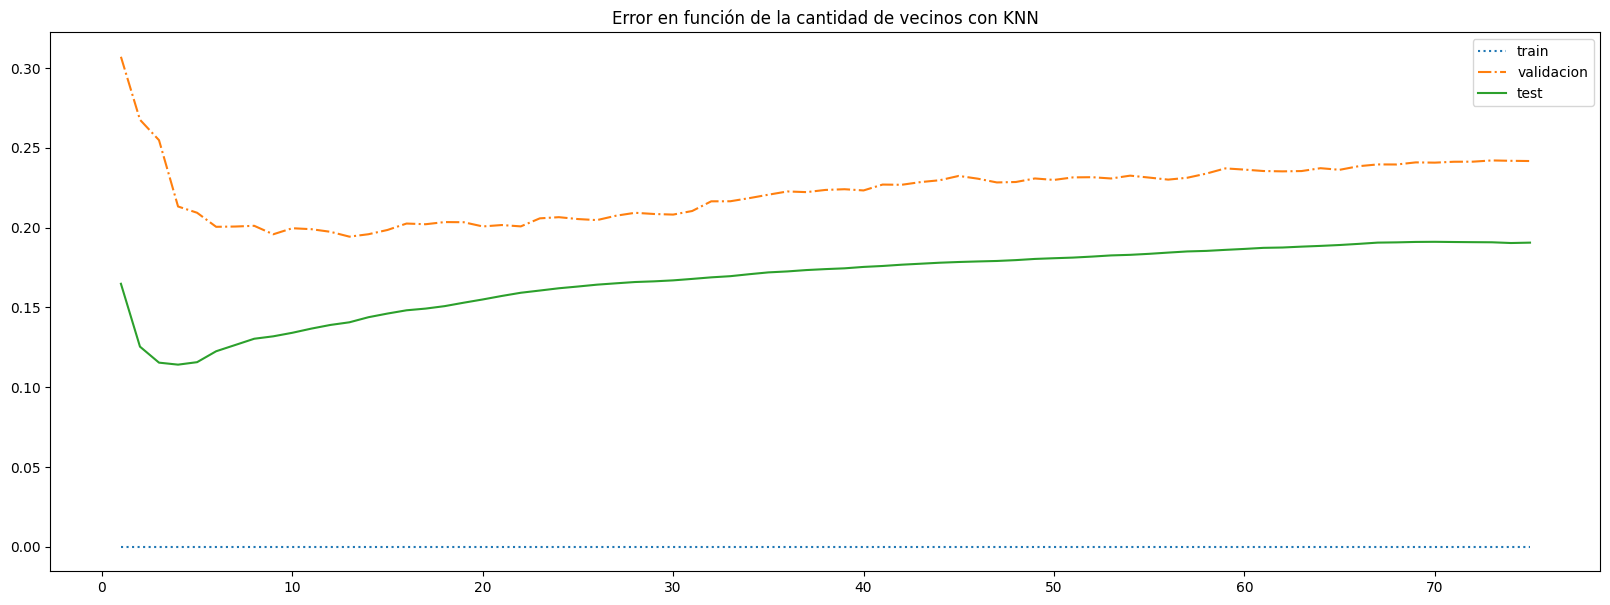

In [14]:
rango = np.array(range(evaluaciones)) * epocas_por_entrenamiento
plt.figure(figsize=(20, 7))
plt.plot(rango, error_train_red, label="train", linestyle=":")
plt.plot(rango, error_val_red, label="validacion", linestyle="-.")
plt.plot(rango, error_test_red, label="test", linestyle="-")
plt.title(f'Error en función de las épocas de entrenamiento con ANN')
plt.legend()
plt.show()

rango = range(1, len(y_train)+1)
plt.figure(figsize=(20, 7))
plt.plot(rango, error_train_knn, label="train", linestyle=":")
plt.plot(rango, error_val_knn, label="validacion", linestyle="-.")
plt.plot(rango, error_test_knn, label="test", linestyle="-")
plt.title(f'Error en función de la cantidad de vecinos con KNN')
plt.legend()
plt.show()

## Sunspots

In [15]:
X_data, y_data = cargar_csv("./data/ssp.data", 12)
X_test, y_test = cargar_csv("./data/ssp.test", 12)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.20)

C:\Users\Certi\AppData\Local\Temp\ipykernel_31364\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
C:\Users\Certi\AppData\Local\Temp\ipykernel_31364\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)


In [16]:
#defino parámetros de la red
epocas_por_entrenamiento=200     #numero de epocas que entrena cada vez
eta=0.05                         #learning rate
alfa=0.3                        #momentum
evaluaciones = 2000
N2 = 6

In [17]:
regr = MLPRegressor(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train_red, error_val_red, error_test_red = entrenar_red(regr, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)

In [18]:
regr_knn = KNeighborsRegressor(weights='distance')

best_knn, error_train_knn, error_val_knn, error_test_knn = entrenar_KNN(regr_knn, len(y_train), X_train, y_train, X_val, y_val, X_test, y_test)

In [19]:
P_test = best_red.predict(X_test)
error_test = mean_squared_error(y_test, P_test)

P_train = best_red.predict(X_train)
error_train = mean_squared_error(y_train, P_train)

P_val = best_red.predict(X_val)
error_val = mean_squared_error(y_val, P_val)

print(f"Error de test de la mejor red: {error_test}")
print(f"Error de train de la mejor red: {error_train}")
print(f"Error de val de la mejor red: {error_val}")

P_test = best_knn.predict(X_test)
error_test = mean_squared_error(y_test, P_test)

P_train = best_knn.predict(X_train)
error_train = mean_squared_error(y_train, P_train)

P_val = best_knn.predict(X_val)
error_val = mean_squared_error(y_val, P_val)

print(f"Error de test del mejor KNN: {error_test}")
print(f"Error de train del mejor KNN: {error_train}")
print(f"Error de val del mejor KNN: {error_val}")

Error de test de la mejor red: 0.005055528940429255
Error de train de la mejor red: 0.004366967597277973
Error de val de la mejor red: 0.0019693194108935013
Error de test del mejor KNN: 0.011343743234295536
Error de train del mejor KNN: 0.0
Error de val del mejor KNN: 0.003505085407211542


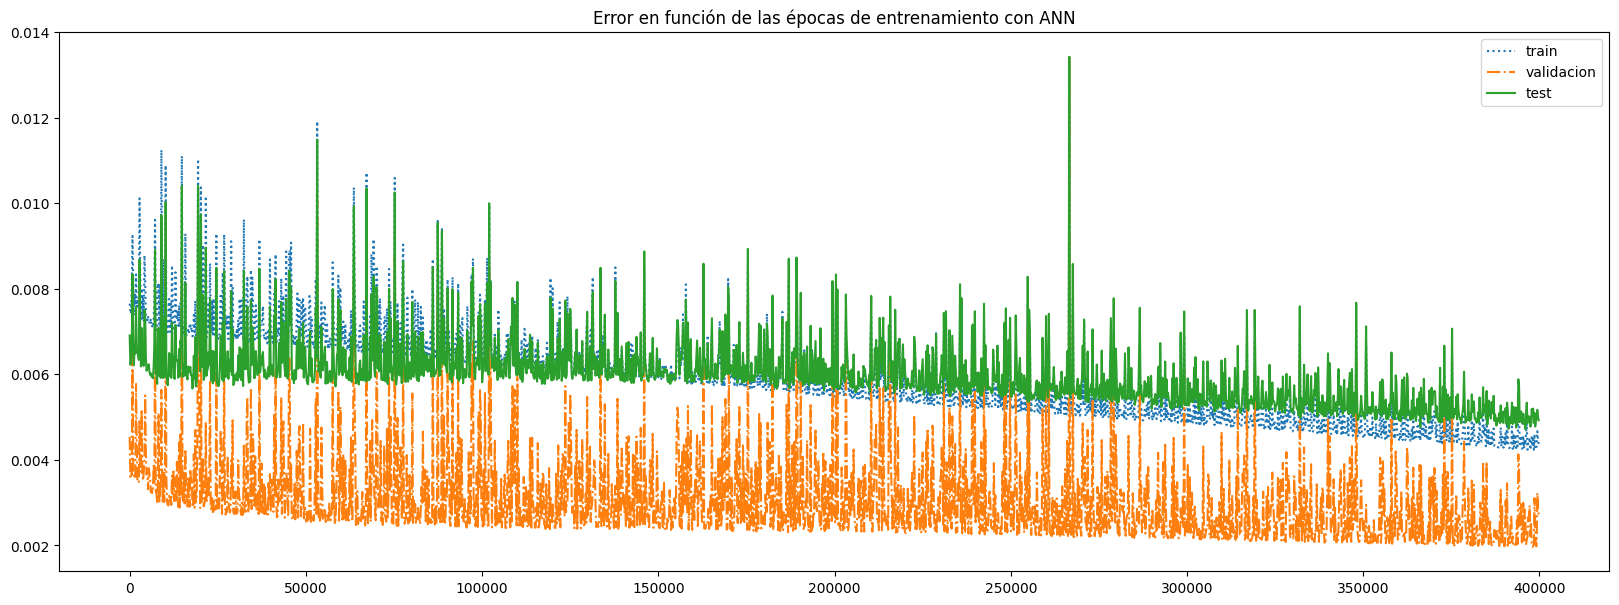

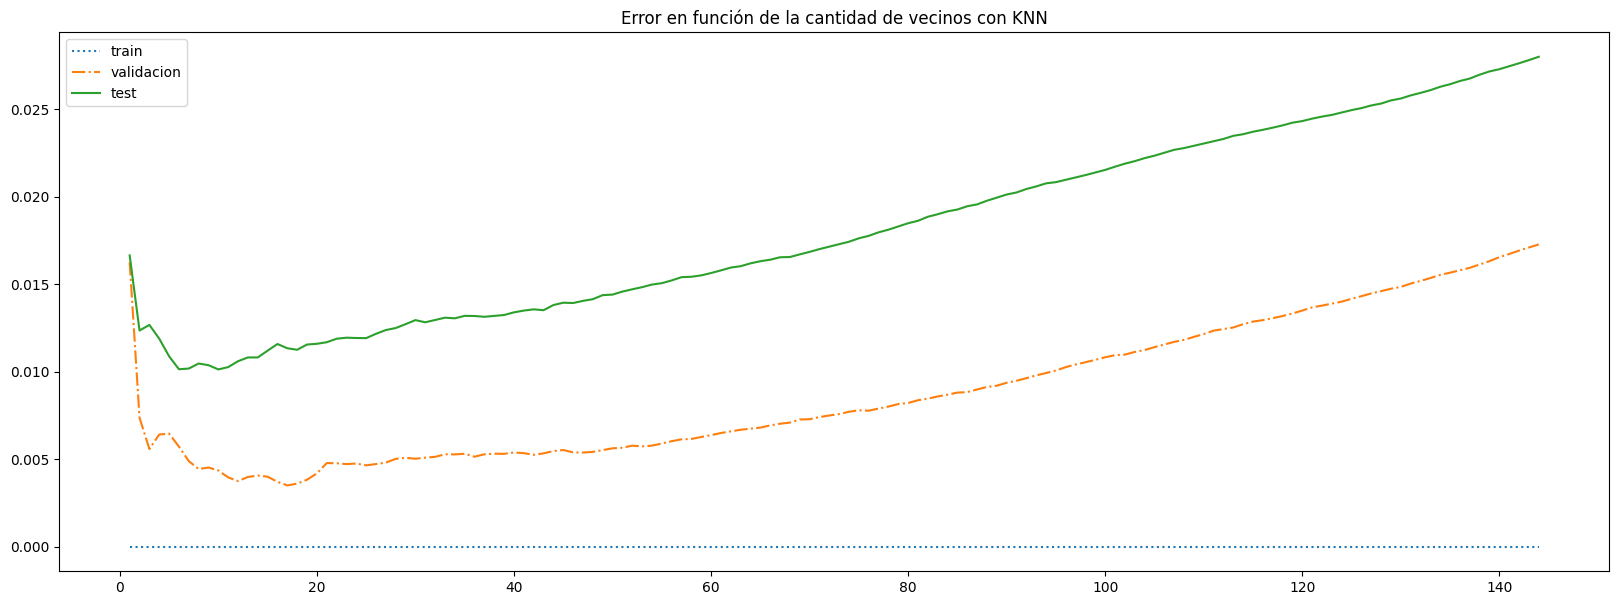

In [20]:
rango = np.array(range(evaluaciones)) * epocas_por_entrenamiento
plt.figure(figsize=(20, 7))
plt.plot(rango, error_train_red, label="train", linestyle=":")
plt.plot(rango, error_val_red, label="validacion", linestyle="-.")
plt.plot(rango, error_test_red, label="test", linestyle="-")
plt.title(f'Error en función de las épocas de entrenamiento con ANN')
plt.legend()
plt.show()

rango = range(1, len(y_train)+1)
plt.figure(figsize=(20, 7))
plt.plot(rango, error_train_knn, label="train", linestyle=":")
plt.plot(rango, error_val_knn, label="validacion", linestyle="-.")
plt.plot(rango, error_test_knn, label="test", linestyle="-")
plt.title(f'Error en función de la cantidad de vecinos con KNN')
plt.legend()
plt.show()

# Ejercicio E

## Funciones de generación de radios de prueba

Si tomamos el radio de la esfera como la distancia mas larga entre todos los puntos de entrenamiento que tenemos sabemos que mientras el punto que queramos evaluar este dentro del convex hull (el polinomio que incluye todos los puntos dentro de si mismo) de los puntos de entrenamiento la esfera que utilice el algoritmo va a incluir todos estos puntos para la evaluación, por lo que el limite superior del tamaño de la esfera es esta distancia.

Ahora, si tomamos el radio como la distancia mas chica entre 2 puntos de entrenamiento sabemos que por lo menos para los puntos de este conjunto al evaluarlos solo se van contener a si mismos dentro de la esfera, por lo que este es un buen limite inferior.

Habiendo definido ambos extremos de nuestro rango, solo nos queda pensar en alguna manera de obtener valores intermedios para probar dentro de este rango.

Para el cálculo de estos radios pense en tres formas, decidi implementar todas y compararlas entre ellas.

El primer método consiste en ...

El segundo método en ...

Y finalmente el tercer método se basa en ...

In [19]:
def calculate_radiuses_1(X_train, count=100):
    distances = []
    for k in range(0, len(y_train)):
        for i in range(k+1, len(y_train)):
            dist = np.linalg.norm(X_train[k]-X_train[i])
            distances.append(dist)
    distances.sort()
    offset = len(distances) // count
    distances = distances[::offset]
    return distances

def calculate_radiuses_2(X_train, count=100):
    distances = []
    for k in range(0, len(y_train)):
        for i in range(k+1, len(y_train)):
            dist = np.linalg.norm(X_train[k]-X_train[i])
            distances.append(dist)
    
    max_dist = max(distances)
    min_dist = min(distances)
    distances = np.linspace(min_dist, max_dist, count)
    return distances

def calculate_radiuses_3(X_train, count=100):
    distances = []
    for k in range(0, len(y_train)):
        for i in range(k+1, len(y_train)):
            dist = np.linalg.norm(X_train[k]-X_train[i])
            distances.append(dist)
    
    max_dist = max(distances)
    min_dist = min(distances)
    min_area = np.pi * min_dist**2
    max_area = np.pi * max_dist**2
    areas = np.linspace(min_area, max_area, count)
    distances = np.sqrt(areas/np.pi)
    return distances

In [20]:
C = 0.78
n_training = 250
n_testing = 10000
d_values = [2, 4, 8, 16, 32]
count_for_avg = 20
count_radius = 200

### Entrenamiento Diagonales

In [21]:
errors_diagonales_knn_radius_distance_1 = {}
errors_diagonales_knn_radius_distance_2 = {}
errors_diagonales_knn_radius_distance_3 = {}
for d in d_values:
  errors_list_knn_radius_distance_1 = []
  errors_list_knn_radius_distance_2 = []
  errors_list_knn_radius_distance_3 = []

  df_test = diagonales(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()
  for i in range(count_for_avg):
    print(f"Diagonales, d={d}, iteración={i}")
    df_train = diagonales(n_training, d, C)
    y_data = df_train["class"].to_numpy()
    X_data = df_train.drop(columns=["class"]).to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)

    radiuses_1 = calculate_radiuses_1(X_train, count_radius if count_radius < ((n_training**2-n_training)/2) else (n_training**2-n_training)/2)
    radiuses_2 = calculate_radiuses_2(X_train, count_radius)
    radiuses_3 = calculate_radiuses_3(X_train, count_radius)

    # KNN Radius distance 1
    clf = RadiusNeighborsClassifier(outlier_label='most_frequent')
    best_clf, train_errors, val_errors, test_errors = entrenar_KNN_radius(clf, radiuses_1, X_train, y_train, X_val, y_val, X_test, y_test)
    P_test = best_clf.predict(X_test)
    error_test = zero_one_loss(y_test, P_test)
    P_train = best_clf.predict(X_train)
    error_train = zero_one_loss(y_train, P_train)
    errors_list_knn_radius_distance_1.append({'error_test': error_test, 'error_train': error_train})
    # KNN Radius distance 2
    clf = RadiusNeighborsClassifier(outlier_label='most_frequent')
    best_clf, train_errors, val_errors, test_errors = entrenar_KNN_radius(clf, radiuses_2, X_train, y_train, X_val, y_val, X_test, y_test)
    P_test = best_clf.predict(X_test)
    error_test = zero_one_loss(y_test, P_test)
    P_train = best_clf.predict(X_train)
    error_train = zero_one_loss(y_train, P_train)
    errors_list_knn_radius_distance_2.append({'error_test': error_test, 'error_train': error_train})
    # KNN Radius distance 3
    clf = RadiusNeighborsClassifier(outlier_label='most_frequent')
    best_clf, train_errors, val_errors, test_errors = entrenar_KNN_radius(clf, radiuses_3, X_train, y_train, X_val, y_val, X_test, y_test)
    P_test = best_clf.predict(X_test)
    error_test = zero_one_loss(y_test, P_test)
    P_train = best_clf.predict(X_train)
    error_train = zero_one_loss(y_train, P_train)
    errors_list_knn_radius_distance_3.append({'error_test': error_test, 'error_train': error_train})
  errors_diagonales_knn_radius_distance_1[d] = errors_list_knn_radius_distance_1
  errors_diagonales_knn_radius_distance_2[d] = errors_list_knn_radius_distance_2
  errors_diagonales_knn_radius_distance_3[d] = errors_list_knn_radius_distance_3

Diagonales, d=2, iteración=0
Diagonales, d=2, iteración=1
Diagonales, d=2, iteración=2
Diagonales, d=2, iteración=3
Diagonales, d=2, iteración=4
Diagonales, d=2, iteración=5
Diagonales, d=2, iteración=6
Diagonales, d=2, iteración=7
Diagonales, d=2, iteración=8
Diagonales, d=2, iteración=9
Diagonales, d=2, iteración=10
Diagonales, d=2, iteración=11
Diagonales, d=2, iteración=12
Diagonales, d=2, iteración=13
Diagonales, d=2, iteración=14
Diagonales, d=2, iteración=15
Diagonales, d=2, iteración=16
Diagonales, d=2, iteración=17
Diagonales, d=2, iteración=18
Diagonales, d=2, iteración=19
Diagonales, d=4, iteración=0
Diagonales, d=4, iteración=1
Diagonales, d=4, iteración=2
Diagonales, d=4, iteración=3
Diagonales, d=4, iteración=4
Diagonales, d=4, iteración=5
Diagonales, d=4, iteración=6
Diagonales, d=4, iteración=7
Diagonales, d=4, iteración=8
Diagonales, d=4, iteración=9
Diagonales, d=4, iteración=10
Diagonales, d=4, iteración=11
Diagonales, d=4, iteración=12
Diagonales, d=4, iteración=13


In [22]:
errors_train_diagonales_knn_radius_distance_1_avg, errors_test_diagonales_knn_radius_distance_1_avg = avg_errors(errors_diagonales_knn_radius_distance_1)
errors_train_diagonales_knn_radius_distance_2_avg, errors_test_diagonales_knn_radius_distance_2_avg = avg_errors(errors_diagonales_knn_radius_distance_2)
errors_train_diagonales_knn_radius_distance_3_avg, errors_test_diagonales_knn_radius_distance_3_avg = avg_errors(errors_diagonales_knn_radius_distance_3)

### Entrenamiento Paralelas

In [23]:
errors_paralelas_knn_radius_distance_1 = {}
errors_paralelas_knn_radius_distance_2 = {}
errors_paralelas_knn_radius_distance_3 = {}
for d in d_values:
  errors_list_knn_radius_distance_1 = []
  errors_list_knn_radius_distance_2 = []
  errors_list_knn_radius_distance_3 = []

  df_test = paralelas(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()
  for i in range(count_for_avg):
    print(f"Paralelas, d={d}, iteración={i}")
    df_train = paralelas(n_training, d, C)
    y_data = df_train["class"].to_numpy()
    X_data = df_train.drop(columns=["class"]).to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)

    radiuses_1 = calculate_radiuses_1(X_train)
    radiuses_2 = calculate_radiuses_2(X_train)
    radiuses_3 = calculate_radiuses_3(X_train)

    # KNN Radius distance 1
    clf = RadiusNeighborsClassifier(outlier_label='most_frequent')
    best_clf, train_errors, val_errors, test_errors = entrenar_KNN_radius(clf, radiuses_1, X_train, y_train, X_val, y_val, X_test, y_test)
    P_test = best_clf.predict(X_test)
    error_test = zero_one_loss(y_test, P_test)
    P_train = best_clf.predict(X_train)
    error_train = zero_one_loss(y_train, P_train)
    errors_list_knn_radius_distance_1.append({'error_test': error_test, 'error_train': error_train})
    # KNN Radius distance 2
    clf = RadiusNeighborsClassifier(outlier_label='most_frequent')
    best_clf, train_errors, val_errors, test_errors = entrenar_KNN_radius(clf, radiuses_2, X_train, y_train, X_val, y_val, X_test, y_test)
    P_test = best_clf.predict(X_test)
    error_test = zero_one_loss(y_test, P_test)
    P_train = best_clf.predict(X_train)
    error_train = zero_one_loss(y_train, P_train)
    errors_list_knn_radius_distance_2.append({'error_test': error_test, 'error_train': error_train})
    # KNN Radius distance 3
    clf = RadiusNeighborsClassifier(outlier_label='most_frequent')
    best_clf, train_errors, val_errors, test_errors = entrenar_KNN_radius(clf, radiuses_3, X_train, y_train, X_val, y_val, X_test, y_test)
    P_test = best_clf.predict(X_test)
    error_test = zero_one_loss(y_test, P_test)
    P_train = best_clf.predict(X_train)
    error_train = zero_one_loss(y_train, P_train)
    errors_list_knn_radius_distance_3.append({'error_test': error_test, 'error_train': error_train})
  errors_paralelas_knn_radius_distance_1[d] = errors_list_knn_radius_distance_1
  errors_paralelas_knn_radius_distance_2[d] = errors_list_knn_radius_distance_2
  errors_paralelas_knn_radius_distance_3[d] = errors_list_knn_radius_distance_3

Paralelas, d=2, iteración=0
Paralelas, d=2, iteración=1
Paralelas, d=2, iteración=2
Paralelas, d=2, iteración=3
Paralelas, d=2, iteración=4
Paralelas, d=2, iteración=5
Paralelas, d=2, iteración=6
Paralelas, d=2, iteración=7
Paralelas, d=2, iteración=8
Paralelas, d=2, iteración=9
Paralelas, d=2, iteración=10
Paralelas, d=2, iteración=11
Paralelas, d=2, iteración=12
Paralelas, d=2, iteración=13
Paralelas, d=2, iteración=14
Paralelas, d=2, iteración=15
Paralelas, d=2, iteración=16
Paralelas, d=2, iteración=17
Paralelas, d=2, iteración=18
Paralelas, d=2, iteración=19
Paralelas, d=4, iteración=0
Paralelas, d=4, iteración=1
Paralelas, d=4, iteración=2
Paralelas, d=4, iteración=3
Paralelas, d=4, iteración=4
Paralelas, d=4, iteración=5
Paralelas, d=4, iteración=6
Paralelas, d=4, iteración=7
Paralelas, d=4, iteración=8
Paralelas, d=4, iteración=9
Paralelas, d=4, iteración=10
Paralelas, d=4, iteración=11
Paralelas, d=4, iteración=12
Paralelas, d=4, iteración=13
Paralelas, d=4, iteración=14
Paral

In [24]:
errors_train_paralelas_knn_radius_distance_1_avg, errors_test_paralelas_knn_radius_distance_1_avg = avg_errors(errors_paralelas_knn_radius_distance_1)
errors_train_paralelas_knn_radius_distance_2_avg, errors_test_paralelas_knn_radius_distance_2_avg = avg_errors(errors_paralelas_knn_radius_distance_2)
errors_train_paralelas_knn_radius_distance_3_avg, errors_test_paralelas_knn_radius_distance_3_avg = avg_errors(errors_paralelas_knn_radius_distance_3)

### Gráficas de comparacion entre los metodos

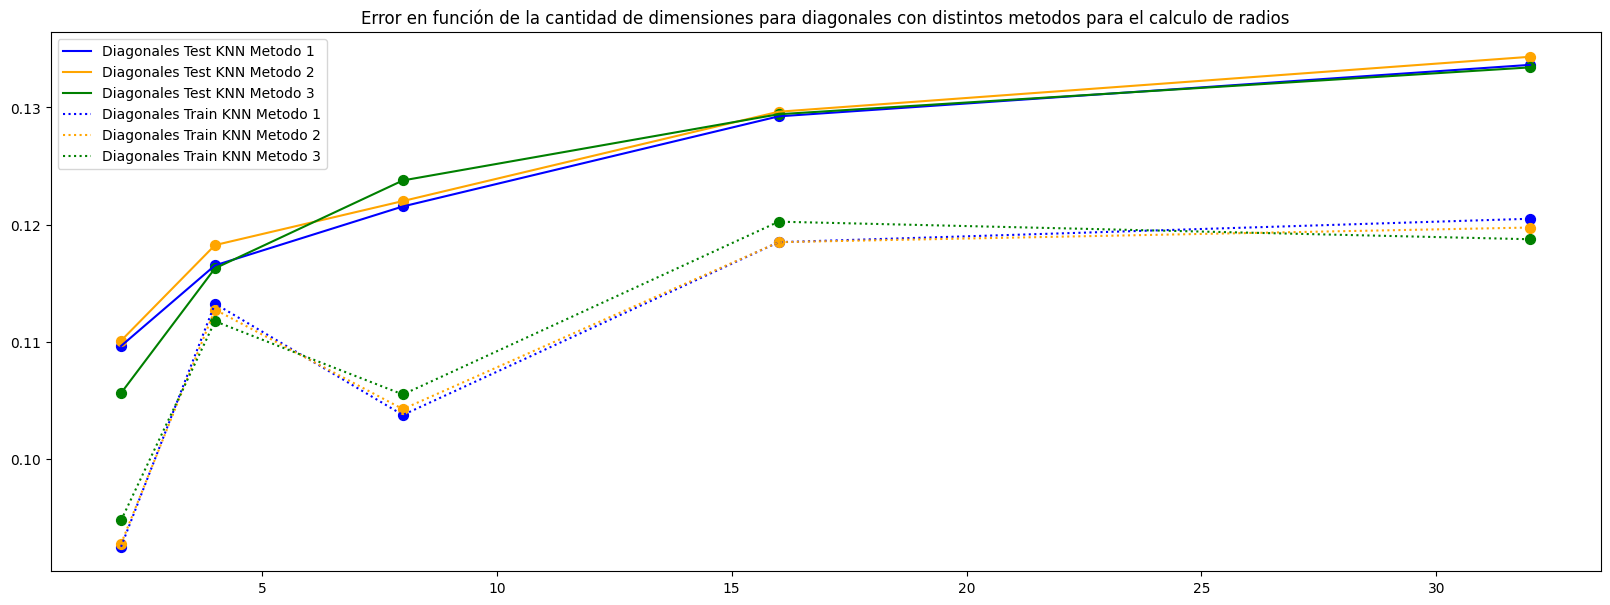

In [25]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_diagonales_knn_radius_distance_1_avg, label="Diagonales Test KNN Metodo 1", linestyle="-", color='blue')
plt.plot(d_values, errors_test_diagonales_knn_radius_distance_2_avg, label="Diagonales Test KNN Metodo 2", linestyle="-", color='orange')
plt.plot(d_values, errors_test_diagonales_knn_radius_distance_3_avg, label="Diagonales Test KNN Metodo 3", linestyle="-", color='green')

plt.plot(d_values, errors_train_diagonales_knn_radius_distance_1_avg, label="Diagonales Train KNN Metodo 1", linestyle=":", color='blue')
plt.plot(d_values, errors_train_diagonales_knn_radius_distance_2_avg, label="Diagonales Train KNN Metodo 2", linestyle=":", color='orange')
plt.plot(d_values, errors_train_diagonales_knn_radius_distance_3_avg, label="Diagonales Train KNN Metodo 3", linestyle=":", color='green')

plt.scatter(d_values, errors_test_diagonales_knn_radius_distance_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_diagonales_knn_radius_distance_2_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_diagonales_knn_radius_distance_3_avg, color='green', s=50)  # puntos en verde

plt.scatter(d_values, errors_train_diagonales_knn_radius_distance_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_diagonales_knn_radius_distance_2_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_diagonales_knn_radius_distance_3_avg, color='green', s=50)  # puntos en verde

plt.title(f'Error en función de la cantidad de dimensiones para diagonales con distintos metodos para el calculo de radios')
plt.legend()
plt.show()

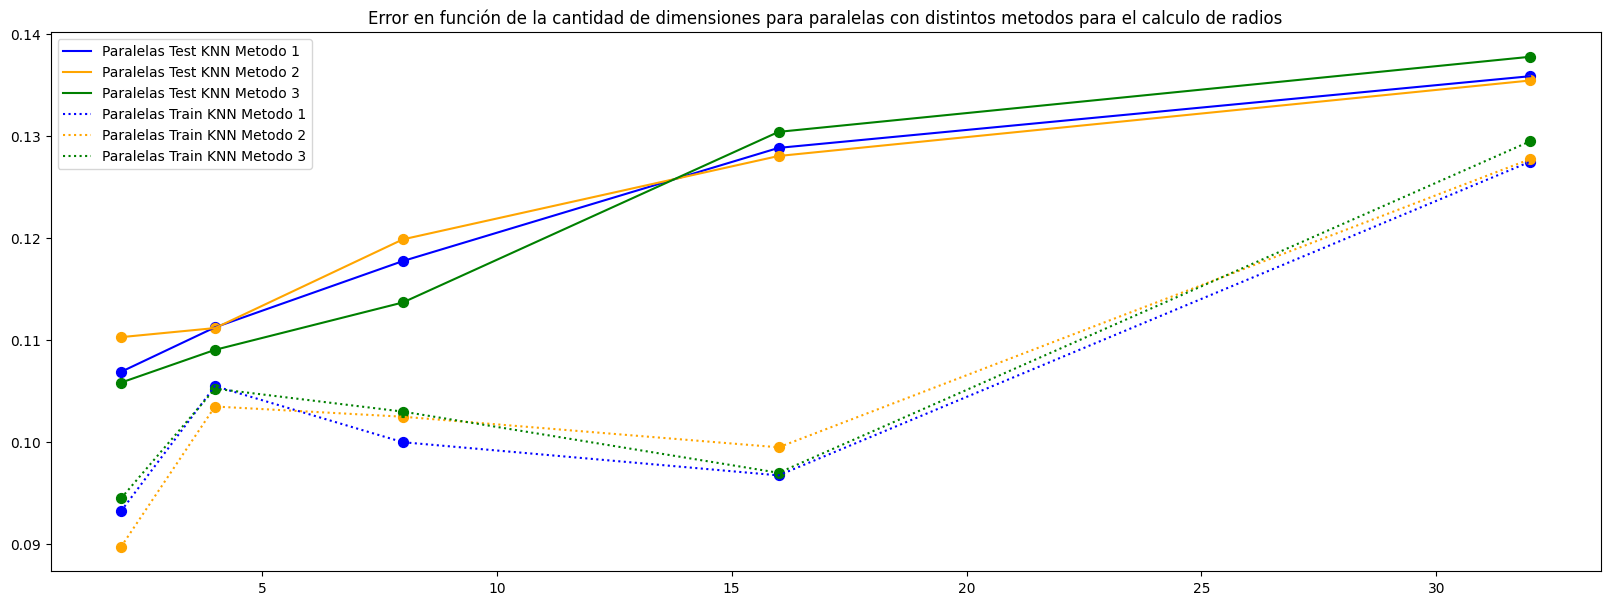

In [26]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_paralelas_knn_radius_distance_1_avg, label="Paralelas Test KNN Metodo 1", linestyle="-", color='blue')
plt.plot(d_values, errors_test_paralelas_knn_radius_distance_2_avg, label="Paralelas Test KNN Metodo 2", linestyle="-", color='orange')
plt.plot(d_values, errors_test_paralelas_knn_radius_distance_3_avg, label="Paralelas Test KNN Metodo 3", linestyle="-", color='green')

plt.plot(d_values, errors_train_paralelas_knn_radius_distance_1_avg, label="Paralelas Train KNN Metodo 1", linestyle=":", color='blue')
plt.plot(d_values, errors_train_paralelas_knn_radius_distance_2_avg, label="Paralelas Train KNN Metodo 2", linestyle=":", color='orange')
plt.plot(d_values, errors_train_paralelas_knn_radius_distance_3_avg, label="Paralelas Train KNN Metodo 3", linestyle=":", color='green')

plt.scatter(d_values, errors_test_paralelas_knn_radius_distance_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_paralelas_knn_radius_distance_2_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_paralelas_knn_radius_distance_3_avg, color='green', s=50)  # puntos en verde

plt.scatter(d_values, errors_train_paralelas_knn_radius_distance_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_paralelas_knn_radius_distance_2_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_paralelas_knn_radius_distance_3_avg, color='green', s=50)  # puntos en verde

plt.title(f'Error en función de la cantidad de dimensiones para paralelas con distintos metodos para el calculo de radios')
plt.legend()
plt.show()

En general los tres metodos funcionaron muy parecido y sacando casos particulares siempre los resultados fueron muy cercanos. Se puede ver que el tercer método fue el que obtuvo un mejor resultado en ciertos casos y un comportamiento muy cercano a los otros en el resto. Es por esto que lo elijo para comparar con los otros métodos del punto c.

## Comparación con EJ C

In [27]:
C = 0.78
n_training = 250
n_testing = 10000
d_values = [2, 4, 8, 16, 32]
count_for_avg = 20
k_fijo = 50
max_k = 200
count_radius = 200

### Entrenamiento Diagonales

In [28]:
errors_diagonales_knn_1 = {}
errors_diagonales_knn_best = {}
errors_diagonales_knn_weighted_fijo = {}
errors_diagonales_knn_weighted_best = {}
errors_diagonales_knn_radius_distance_3 = {}
for d in d_values:
  errors_list_knn_1 = []
  errors_list_knn_best = []
  errors_list_knn_weighted_fijo = []
  errors_list_knn_weighted_best = []
  errors_list_knn_radius_distance_3 = []

  df_test = diagonales(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()
  for i in range(count_for_avg):
    print(f"Diagonales, d={d}, iteración={i}")
    df_train = diagonales(n_training, d, C)
    y_data = df_train["class"].to_numpy()
    X_data = df_train.drop(columns=["class"]).to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)

    radiuses_3 = calculate_radiuses_3(X_train, count_radius)

    # KNN Radius distance 3
    clf = RadiusNeighborsClassifier(outlier_label='most_frequent')
    best_clf, train_errors, val_errors, test_errors = entrenar_KNN_radius(clf, radiuses_3, X_train, y_train, X_val, y_val, X_test, y_test)
    P_test = best_clf.predict(X_test)
    error_test = zero_one_loss(y_test, P_test)
    P_train = best_clf.predict(X_train)
    error_train = zero_one_loss(y_train, P_train)
    errors_list_knn_radius_distance_3.append({'error_test': error_test, 'error_train': error_train})
    # KNN
    clf = KNeighborsClassifier()
    best_clf_KNN, train_errors_KNN, _, test_errors_KNN = entrenar_KNN(clf, max_k, X_train, y_train, X_val, y_val, X_test, y_test)
    errors_list_knn_1.append({'error_test': test_errors_KNN[0], 'error_train': train_errors_KNN[0]})
    errors_list_knn_best.append({'error_test': test_errors_KNN[best_clf_KNN.n_neighbors-1], 'error_train': train_errors_KNN[best_clf_KNN.n_neighbors-1]})
    # KNN weighted
    clf = KNeighborsClassifier(weights='distance')
    best_clf_KNN, train_errors_KNN, _, test_errors_KNN = entrenar_KNN(clf, max_k, X_train, y_train, X_val, y_val, X_test, y_test)
    errors_list_knn_weighted_fijo.append({'error_test': test_errors_KNN[k_fijo-1], 'error_train': train_errors_KNN[k_fijo-1]})
    errors_list_knn_weighted_best.append({'error_test': test_errors_KNN[best_clf_KNN.n_neighbors-1], 'error_train': train_errors_KNN[best_clf_KNN.n_neighbors-1]})
  errors_diagonales_knn_1[d] = errors_list_knn_1
  errors_diagonales_knn_best[d] = errors_list_knn_best
  errors_diagonales_knn_weighted_fijo[d] = errors_list_knn_weighted_fijo
  errors_diagonales_knn_weighted_best[d] = errors_list_knn_weighted_best
  errors_diagonales_knn_radius_distance_3[d] = errors_list_knn_radius_distance_3

Diagonales, d=2, iteración=0
Diagonales, d=2, iteración=1
Diagonales, d=2, iteración=2
Diagonales, d=2, iteración=3
Diagonales, d=2, iteración=4
Diagonales, d=2, iteración=5
Diagonales, d=2, iteración=6
Diagonales, d=2, iteración=7
Diagonales, d=2, iteración=8
Diagonales, d=2, iteración=9
Diagonales, d=2, iteración=10
Diagonales, d=2, iteración=11
Diagonales, d=2, iteración=12
Diagonales, d=2, iteración=13
Diagonales, d=2, iteración=14
Diagonales, d=2, iteración=15
Diagonales, d=2, iteración=16
Diagonales, d=2, iteración=17
Diagonales, d=2, iteración=18
Diagonales, d=2, iteración=19
Diagonales, d=4, iteración=0
Diagonales, d=4, iteración=1
Diagonales, d=4, iteración=2
Diagonales, d=4, iteración=3
Diagonales, d=4, iteración=4
Diagonales, d=4, iteración=5
Diagonales, d=4, iteración=6
Diagonales, d=4, iteración=7
Diagonales, d=4, iteración=8
Diagonales, d=4, iteración=9
Diagonales, d=4, iteración=10
Diagonales, d=4, iteración=11
Diagonales, d=4, iteración=12
Diagonales, d=4, iteración=13


In [29]:
errors_train_diagonales_knn_1_avg, errors_test_diagonales_knn_1_avg = avg_errors(errors_diagonales_knn_1)
errors_train_diagonales_knn_best_avg, errors_test_diagonales_knn_best_avg = avg_errors(errors_diagonales_knn_best)
errors_train_diagonales_knn_weighted_fijo_avg, errors_test_diagonales_knn_weighted_fijo_avg = avg_errors(errors_diagonales_knn_weighted_fijo)
errors_train_diagonales_knn_weighted_best_avg, errors_test_diagonales_knn_weighted_best_avg = avg_errors(errors_diagonales_knn_weighted_best)
errors_train_diagonales_knn_radius_distance_3_avg, errors_test_diagonales_knn_radius_distance_3_avg = avg_errors(errors_diagonales_knn_radius_distance_3)

### Entrenamiento Paralelas

In [30]:
errors_paralelas_knn_1 = {}
errors_paralelas_knn_best = {}
errors_paralelas_knn_weighted_fijo = {}
errors_paralelas_knn_weighted_best = {}
errors_paralelas_knn_radius_distance_3 = {}
for d in d_values:
  errors_list_knn_1 = []
  errors_list_knn_best = []
  errors_list_knn_weighted_fijo = []
  errors_list_knn_weighted_best = []
  errors_list_knn_radius_distance_3 = []

  df_test = paralelas(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()
  for i in range(count_for_avg):
    print(f"Paralelas, d={d}, iteración={i}")
    df_train = paralelas(n_training, d, C)
    y_data = df_train["class"].to_numpy()
    X_data = df_train.drop(columns=["class"]).to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)

    radiuses_3 = calculate_radiuses_3(X_train)

    # KNN Radius distance 3
    clf = RadiusNeighborsClassifier(outlier_label='most_frequent')
    best_clf, train_errors, val_errors, test_errors = entrenar_KNN_radius(clf, radiuses_3, X_train, y_train, X_val, y_val, X_test, y_test)
    P_test = best_clf.predict(X_test)
    error_test = zero_one_loss(y_test, P_test)
    P_train = best_clf.predict(X_train)
    error_train = zero_one_loss(y_train, P_train)
    errors_list_knn_radius_distance_3.append({'error_test': error_test, 'error_train': error_train})
    # KNN
    clf = KNeighborsClassifier()
    best_clf_KNN, train_errors_KNN, _, test_errors_KNN = entrenar_KNN(clf, max_k, X_train, y_train, X_val, y_val, X_test, y_test)
    errors_list_knn_1.append({'error_test': test_errors_KNN[0], 'error_train': train_errors_KNN[0]})
    errors_list_knn_best.append({'error_test': test_errors_KNN[best_clf_KNN.n_neighbors-1], 'error_train': train_errors_KNN[best_clf_KNN.n_neighbors-1]})
    # KNN weighted
    clf = KNeighborsClassifier(weights='distance')
    best_clf_KNN, train_errors_KNN, _, test_errors_KNN = entrenar_KNN(clf, max_k, X_train, y_train, X_val, y_val, X_test, y_test)
    errors_list_knn_weighted_fijo.append({'error_test': test_errors_KNN[k_fijo-1], 'error_train': train_errors_KNN[k_fijo-1]})
    errors_list_knn_weighted_best.append({'error_test': test_errors_KNN[best_clf_KNN.n_neighbors-1], 'error_train': train_errors_KNN[best_clf_KNN.n_neighbors-1]})
  errors_paralelas_knn_1[d] = errors_list_knn_1
  errors_paralelas_knn_best[d] = errors_list_knn_best
  errors_paralelas_knn_weighted_fijo[d] = errors_list_knn_weighted_fijo
  errors_paralelas_knn_weighted_best[d] = errors_list_knn_weighted_best
  errors_paralelas_knn_radius_distance_3[d] = errors_list_knn_radius_distance_3

Paralelas, d=2, iteración=0
Paralelas, d=2, iteración=1
Paralelas, d=2, iteración=2
Paralelas, d=2, iteración=3
Paralelas, d=2, iteración=4
Paralelas, d=2, iteración=5
Paralelas, d=2, iteración=6
Paralelas, d=2, iteración=7
Paralelas, d=2, iteración=8
Paralelas, d=2, iteración=9
Paralelas, d=2, iteración=10
Paralelas, d=2, iteración=11
Paralelas, d=2, iteración=12
Paralelas, d=2, iteración=13
Paralelas, d=2, iteración=14
Paralelas, d=2, iteración=15
Paralelas, d=2, iteración=16
Paralelas, d=2, iteración=17
Paralelas, d=2, iteración=18
Paralelas, d=2, iteración=19
Paralelas, d=4, iteración=0
Paralelas, d=4, iteración=1
Paralelas, d=4, iteración=2
Paralelas, d=4, iteración=3
Paralelas, d=4, iteración=4
Paralelas, d=4, iteración=5
Paralelas, d=4, iteración=6
Paralelas, d=4, iteración=7
Paralelas, d=4, iteración=8
Paralelas, d=4, iteración=9
Paralelas, d=4, iteración=10
Paralelas, d=4, iteración=11
Paralelas, d=4, iteración=12
Paralelas, d=4, iteración=13
Paralelas, d=4, iteración=14
Paral

In [31]:
errors_train_paralelas_knn_1_avg, errors_test_paralelas_knn_1_avg = avg_errors(errors_paralelas_knn_1)
errors_train_paralelas_knn_best_avg, errors_test_paralelas_knn_best_avg = avg_errors(errors_paralelas_knn_best)
errors_train_paralelas_knn_weighted_fijo_avg, errors_test_paralelas_knn_weighted_fijo_avg = avg_errors(errors_paralelas_knn_weighted_fijo)
errors_train_paralelas_knn_weighted_best_avg, errors_test_paralelas_knn_weighted_best_avg = avg_errors(errors_paralelas_knn_weighted_best)
errors_train_paralelas_knn_radius_distance_3_avg, errors_test_paralelas_knn_radius_distance_3_avg = avg_errors(errors_paralelas_knn_radius_distance_3)

### Gráficas

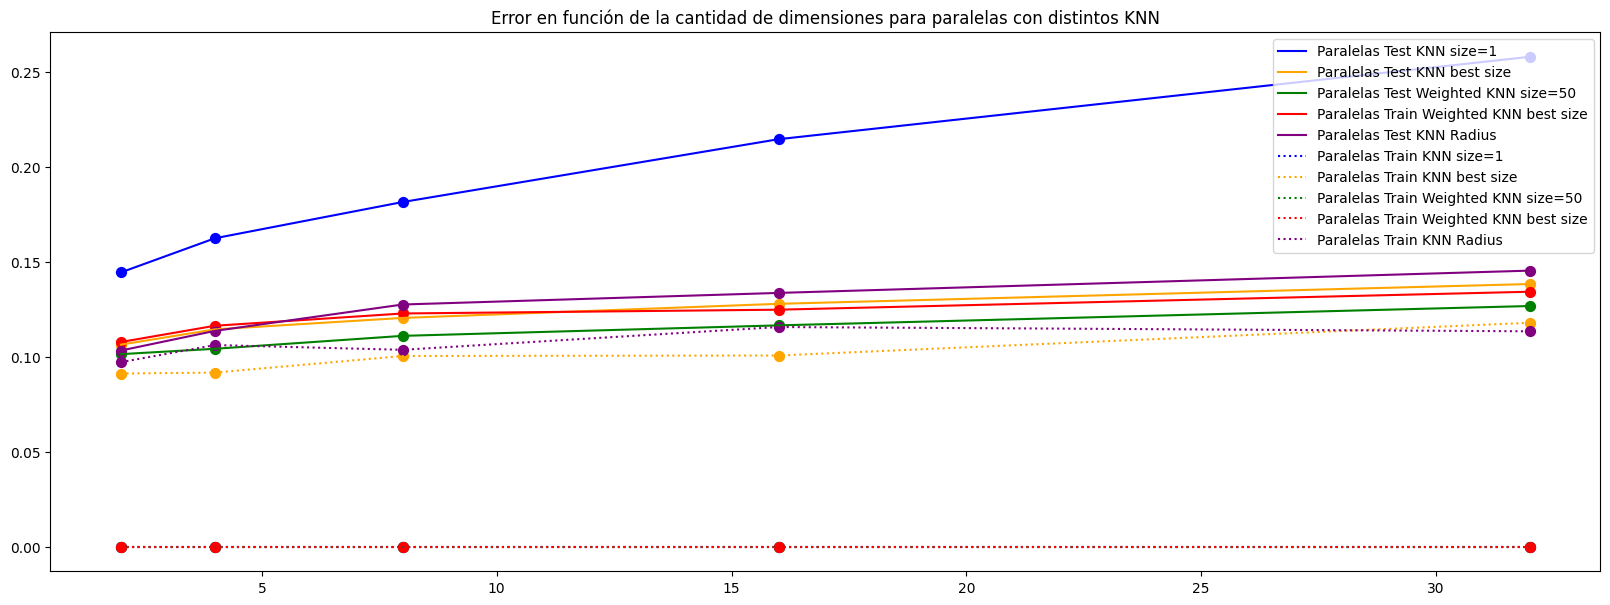

In [32]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_paralelas_knn_1_avg, label="Paralelas Test KNN size=1", linestyle="-", color='blue')
plt.plot(d_values, errors_test_paralelas_knn_best_avg, label="Paralelas Test KNN best size", linestyle="-", color='orange')
plt.plot(d_values, errors_test_paralelas_knn_weighted_fijo_avg, label="Paralelas Test Weighted KNN size=50", linestyle="-", color='green')
plt.plot(d_values, errors_test_paralelas_knn_weighted_best_avg, label="Paralelas Train Weighted KNN best size", linestyle="-", color='red')
plt.plot(d_values, errors_test_paralelas_knn_radius_distance_3_avg, label="Paralelas Test KNN Radius", linestyle="-", color='purple')

plt.plot(d_values, errors_train_paralelas_knn_1_avg, label="Paralelas Train KNN size=1", linestyle=":", color='blue')
plt.plot(d_values, errors_train_paralelas_knn_best_avg, label="Paralelas Train KNN best size", linestyle=":", color='orange')
plt.plot(d_values, errors_train_paralelas_knn_weighted_fijo_avg, label="Paralelas Train Weighted KNN size=50", linestyle=":", color='green')
plt.plot(d_values, errors_train_paralelas_knn_weighted_best_avg, label="Paralelas Train Weighted KNN best size", linestyle=":", color='red')
plt.plot(d_values, errors_train_paralelas_knn_radius_distance_3_avg, label="Paralelas Train KNN Radius", linestyle=":", color='purple')

plt.scatter(d_values, errors_test_paralelas_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_paralelas_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_paralelas_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_paralelas_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_test_paralelas_knn_radius_distance_3_avg, color='purple', s=50)  # puntos en violeta

plt.scatter(d_values, errors_train_paralelas_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_paralelas_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_paralelas_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_paralelas_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_paralelas_knn_radius_distance_3_avg, color='purple', s=50)  # puntos en violeta

plt.title(f'Error en función de la cantidad de dimensiones para paralelas con distintos KNN')
plt.legend()
plt.show()

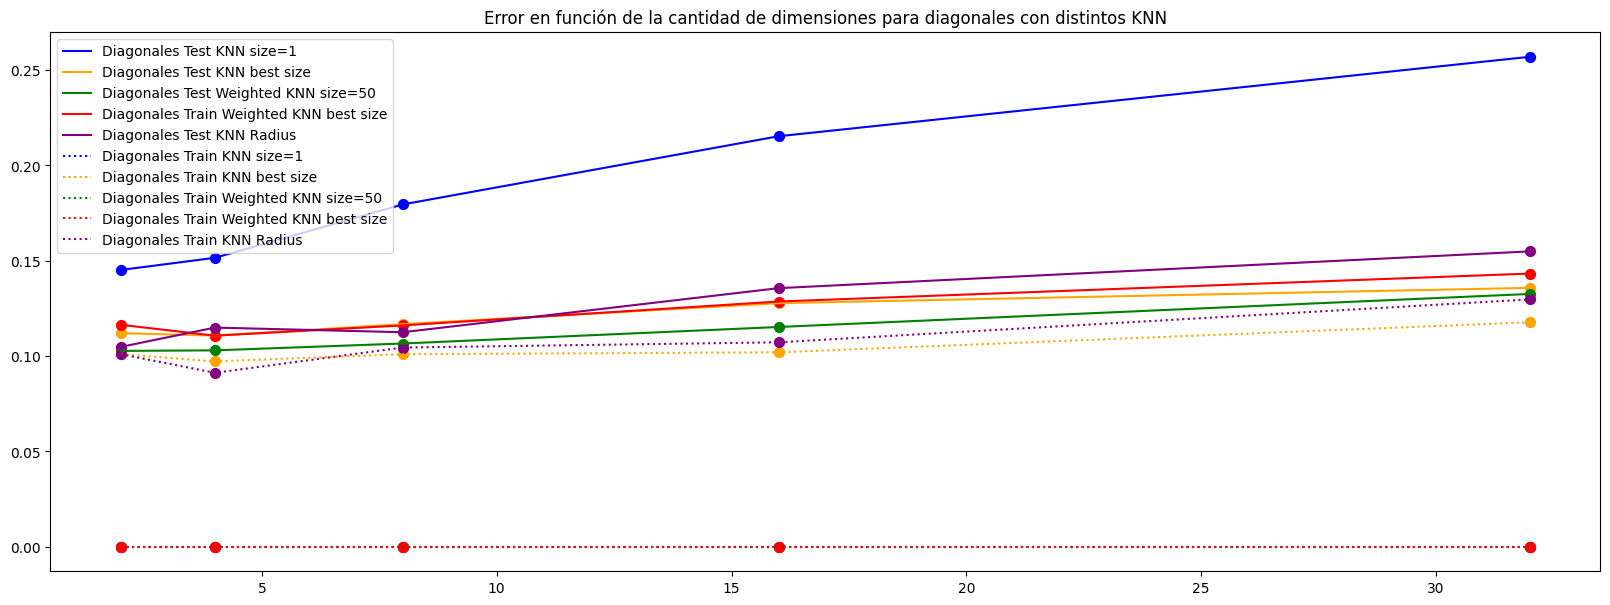

In [33]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_diagonales_knn_1_avg, label="Diagonales Test KNN size=1", linestyle="-", color='blue')
plt.plot(d_values, errors_test_diagonales_knn_best_avg, label="Diagonales Test KNN best size", linestyle="-", color='orange')
plt.plot(d_values, errors_test_diagonales_knn_weighted_fijo_avg, label="Diagonales Test Weighted KNN size=50", linestyle="-", color='green')
plt.plot(d_values, errors_test_diagonales_knn_weighted_best_avg, label="Diagonales Train Weighted KNN best size", linestyle="-", color='red')
plt.plot(d_values, errors_test_diagonales_knn_radius_distance_3_avg, label="Diagonales Test KNN Radius", linestyle="-", color='purple')

plt.plot(d_values, errors_train_diagonales_knn_1_avg, label="Diagonales Train KNN size=1", linestyle=":", color='blue')
plt.plot(d_values, errors_train_diagonales_knn_best_avg, label="Diagonales Train KNN best size", linestyle=":", color='orange')
plt.plot(d_values, errors_train_diagonales_knn_weighted_fijo_avg, label="Diagonales Train Weighted KNN size=50", linestyle=":", color='green')
plt.plot(d_values, errors_train_diagonales_knn_weighted_best_avg, label="Diagonales Train Weighted KNN best size", linestyle=":", color='red')
plt.plot(d_values, errors_train_diagonales_knn_radius_distance_3_avg, label="Diagonales Train KNN Radius", linestyle=":", color='purple')

plt.scatter(d_values, errors_test_diagonales_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_diagonales_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_diagonales_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_diagonales_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_test_diagonales_knn_radius_distance_3_avg, color='purple', s=50)  # puntos en violeta

plt.scatter(d_values, errors_train_diagonales_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_diagonales_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_diagonales_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_diagonales_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_diagonales_knn_radius_distance_3_avg, color='purple', s=50)  # puntos en violeta

plt.title(f'Error en función de la cantidad de dimensiones para diagonales con distintos KNN')
plt.legend()
plt.show()

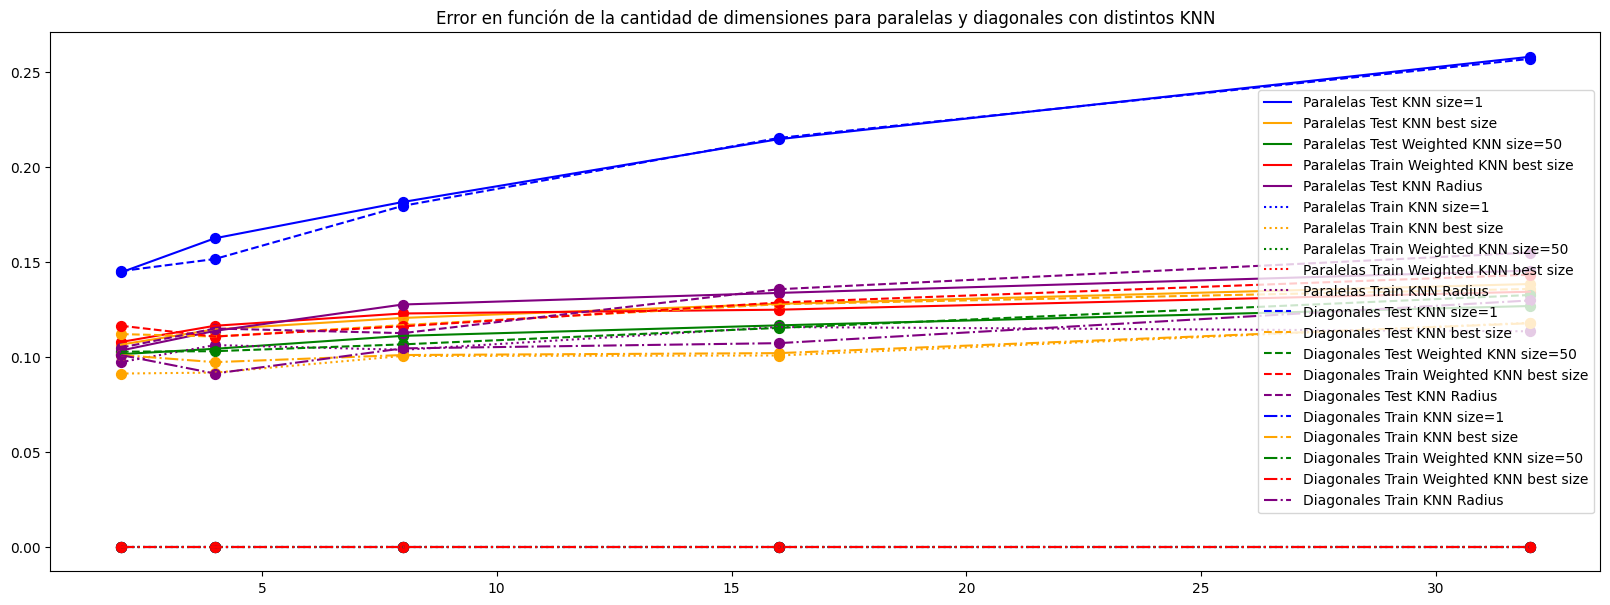

In [34]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_paralelas_knn_1_avg, label="Paralelas Test KNN size=1", linestyle="-", color='blue')
plt.plot(d_values, errors_test_paralelas_knn_best_avg, label="Paralelas Test KNN best size", linestyle="-", color='orange')
plt.plot(d_values, errors_test_paralelas_knn_weighted_fijo_avg, label="Paralelas Test Weighted KNN size=50", linestyle="-", color='green')
plt.plot(d_values, errors_test_paralelas_knn_weighted_best_avg, label="Paralelas Train Weighted KNN best size", linestyle="-", color='red')
plt.plot(d_values, errors_test_paralelas_knn_radius_distance_3_avg, label="Paralelas Test KNN Radius", linestyle="-", color='purple')

plt.plot(d_values, errors_train_paralelas_knn_1_avg, label="Paralelas Train KNN size=1", linestyle=":", color='blue')
plt.plot(d_values, errors_train_paralelas_knn_best_avg, label="Paralelas Train KNN best size", linestyle=":", color='orange')
plt.plot(d_values, errors_train_paralelas_knn_weighted_fijo_avg, label="Paralelas Train Weighted KNN size=50", linestyle=":", color='green')
plt.plot(d_values, errors_train_paralelas_knn_weighted_best_avg, label="Paralelas Train Weighted KNN best size", linestyle=":", color='red')
plt.plot(d_values, errors_train_paralelas_knn_radius_distance_3_avg, label="Paralelas Train KNN Radius", linestyle=":", color='purple')

plt.plot(d_values, errors_test_diagonales_knn_1_avg, label="Diagonales Test KNN size=1", linestyle="--", color='blue')
plt.plot(d_values, errors_test_diagonales_knn_best_avg, label="Diagonales Test KNN best size", linestyle="--", color='orange')
plt.plot(d_values, errors_test_diagonales_knn_weighted_fijo_avg, label="Diagonales Test Weighted KNN size=50", linestyle="--", color='green')
plt.plot(d_values, errors_test_diagonales_knn_weighted_best_avg, label="Diagonales Train Weighted KNN best size", linestyle="--", color='red')
plt.plot(d_values, errors_test_diagonales_knn_radius_distance_3_avg, label="Diagonales Test KNN Radius", linestyle="--", color='purple')

plt.plot(d_values, errors_train_diagonales_knn_1_avg, label="Diagonales Train KNN size=1", linestyle="-.", color='blue')
plt.plot(d_values, errors_train_diagonales_knn_best_avg, label="Diagonales Train KNN best size", linestyle="-.", color='orange')
plt.plot(d_values, errors_train_diagonales_knn_weighted_fijo_avg, label="Diagonales Train Weighted KNN size=50", linestyle="-.", color='green')
plt.plot(d_values, errors_train_diagonales_knn_weighted_best_avg, label="Diagonales Train Weighted KNN best size", linestyle="-.", color='red')
plt.plot(d_values, errors_train_diagonales_knn_radius_distance_3_avg, label="Diagonales Train KNN Radius", linestyle="-.", color='purple')

plt.scatter(d_values, errors_test_paralelas_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_paralelas_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_paralelas_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_paralelas_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_test_paralelas_knn_radius_distance_3_avg, color='purple', s=50)  # puntos en violeta

plt.scatter(d_values, errors_train_paralelas_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_paralelas_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_paralelas_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_paralelas_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_paralelas_knn_radius_distance_3_avg, color='purple', s=50)  # puntos en violeta

plt.scatter(d_values, errors_test_diagonales_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_diagonales_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_diagonales_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_diagonales_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_test_diagonales_knn_radius_distance_3_avg, color='purple', s=50)  # puntos en violeta

plt.scatter(d_values, errors_train_diagonales_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_diagonales_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_diagonales_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_diagonales_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_diagonales_knn_radius_distance_3_avg, color='purple', s=50)  # puntos en violeta

plt.title(f'Error en función de la cantidad de dimensiones para paralelas y diagonales con distintos KNN')
plt.legend()
plt.show()

### Análisis

# Ejercicio F

In [173]:
content_multiplier = 1
collaborative_multiplier = 1
movies_count = 7
users_count = 3
df_movies = pd.read_csv('./data/pelis.csv')
df_users = pd.read_csv('./data/usuarios.csv')

In [174]:
def create_movie_classifier(df, ids_to_remove):
    df = df.drop(ids_to_remove)
    ids = df["ID"].to_numpy()
    y = df["ID"].to_numpy()
    X = df.drop(columns=["ID"]).to_numpy()
    clf = KNeighborsClassifier()
    clf.fit(X, y)
    return ids, clf

In [175]:
def create_user_classifier(df, ids_to_keep):
    df = df.drop(columns=["U9", "U10"])
    df = df.loc[df['ID'].isin([x+1 for x in ids_to_keep])]
    df = df.transpose()
    X = df.to_numpy()
    X = X[1:]
    X[np.isnan(X)] = 0
    y = np.arange(0, len(X))
    clf = KNeighborsClassifier()
    clf.fit(X, y)
    return clf

In [176]:
def modifier_by_score(score, use_distance=False, multiplier=1):
    if use_distance:
        if score == 1:
            return (lambda x, d: x-2*(1/d)*multiplier)
        if score == 2:
            return (lambda x, d: x-1*(1/d)*multiplier)
        if score == 3:
            return (lambda x, d: x+1*(1/d)*multiplier)
        if score == 4:
            return (lambda x, d: x+2*(1/d)*multiplier)
        if score == 5:
            return (lambda x, d: x+3*(1/d)*multiplier)
    else:
        if score == 1:
            return (lambda x, d: x-2*multiplier)
        if score == 2:
            return (lambda x, d: x-1*multiplier)
        if score == 3:
            return (lambda x, d: x+1*multiplier)
        if score == 4:
            return (lambda x, d: x+2*multiplier)
        if score == 5:
            return (lambda x, d: x+3*multiplier)

In [177]:
def create_base():
    base = []
    for i in range(len(df_movies["ID"].to_numpy())):
        base.append((i+1, 0))
    return base

In [178]:
def recommend_by_content(movies_watched_by_score, movies_watched, base, use_distance=False):
    ids, clf = create_movie_classifier(df_movies, movies_watched)

    for i in range(len(movies_watched_by_score)):
        for movie in movies_watched_by_score[i]:
            distances, recommendations = clf.kneighbors([df_movies.drop(columns=["ID"]).iloc[movie].to_numpy()], movies_count, return_distance=True)
            recommendations = recommendations[0]
            distances = distances[0]
            for j in range(len(recommendations)):
                movie_id = ids[recommendations[j]]+1
                base[movie_id-1] = (base[movie_id-1][0], modifier_by_score(i, use_distance, content_multiplier)(base[movie_id-1][1], distances[j]))

In [179]:
def recommend_by_users(user_data, movies_watched, base, use_distance=False):
    user_vec = user_data[movies_watched]
    clf = create_user_classifier(df_users, movies_watched)
    distances, users = clf.kneighbors([user_vec], users_count, return_distance=True)
    distances = distances[0]
    users = users[0]
    for up in range(len(users)):
        user = users[up]
        col = "U" + str(user+1)
        user_data = df_users[col].to_numpy()
        for i in range(len(user_data)):
            if not np.isnan(user_data[i]) and i not in movies_watched:
                movie_id = i+1
                base[movie_id-1] = (base[movie_id-1][0], modifier_by_score(user_data[i], use_distance, collaborative_multiplier)(base[movie_id-1][1], distances[up]))

In [180]:
def movie_recommender(user_data, use_distance=False):
    base_scores = create_base()

    movies_watched_by_score = ([], [], [], [], [])
    movies_watched = []
    for i in range(len(user_data)):
        if not np.isnan(user_data[i]):
            movies_watched.append(i)
            movies_watched_by_score[int(user_data[i])].append(i)

    recommend_by_content(movies_watched_by_score, movies_watched, base_scores, use_distance)
    recommend_by_users(user_data, movies_watched, base_scores, use_distance)
    return list(filter(lambda x: x[0]-1 not in movies_watched, base_scores))
            

In [181]:
recommendations = movie_recommender(df_users["U9"].to_numpy(), use_distance=True)
recommendations.sort(key=lambda x: x[1], reverse=True)
print(recommendations)
recommendations = movie_recommender(df_users["U9"].to_numpy(), use_distance=False)
recommendations.sort(key=lambda x: x[1], reverse=True)
print(recommendations)

[(20, 1.5177961366131403), (19, 1.2695232371044682), (18, 1.1547005383792517), (13, 0.7260927096535479), (11, 0.5), (2, 0.4588314677411235), (6, 0.4588314677411235), (14, 0.3779644730092272), (9, 0.2672612419124244), (22, 0.2529654437105141), (10, 0.22941573387056174), (15, 0.14137441202385737), (1, 0), (4, 0), (5, 0), (7, 0), (12, -0.22941573387056174), (3, -0.2672612419124244), (8, -0.2672612419124244), (21, -0.2672612419124244), (16, -0.4472135954999579), (17, -0.49667697578298614)]
[(19, 5), (20, 5), (13, 3), (2, 2), (6, 2), (11, 2), (18, 2), (9, 1), (10, 1), (14, 1), (15, 1), (1, 0), (4, 0), (5, 0), (7, 0), (22, 0), (3, -1), (8, -1), (12, -1), (16, -1), (21, -1), (17, -2)]


In [182]:
recommendations = movie_recommender(df_users["U10"].to_numpy(), use_distance=True)
recommendations.sort(key=lambda x: x[1], reverse=True)
print(recommendations)
recommendations = movie_recommender(df_users["U10"].to_numpy(), use_distance=False)
recommendations.sort(key=lambda x: x[1], reverse=True)
print(recommendations)

[(25, 2.060660171779821), (12, 1.5), (23, 1.3939935051131545), (10, 1.2958758547680684), (5, 1.2226499018873853), (7, 1.1220355269907727), (24, 1.0606601717798212), (9, 1.0028104513481124), (11, 1.0), (13, 0.9379321953496516), (15, 0.7665963353012637), (14, 0.6294530616933871), (8, 0.0014096802925422924), (20, 0), (16, -0.21320071635561041), (21, -0.35355339059327373), (22, -0.35355339059327373), (19, -0.47577565596949917), (4, -0.5), (6, -0.5833333333333333), (18, -0.6666666666666666), (17, -0.8329691244638355)]
[(25, 6), (23, 4), (11, 3), (12, 3), (24, 3), (5, 2), (7, 2), (10, 2), (9, 1), (13, 1), (14, 0), (15, 0), (20, 0), (4, -1), (8, -1), (16, -1), (21, -1), (22, -1), (6, -2), (18, -2), (19, -2), (17, -3)]
